In [1]:
# from circuit_breaking.src import *
%load_ext autoreload
%autoreload 2
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm
print(os.getcwd())
import sys
from transformers import AutoTokenizer, AutoModelForCausalLM
import contextlib
import einops
import wandb
import pandas as pd
import dotenv
from collections import defaultdict
dotenv.load_dotenv()

from huggingface_hub import login

HF_ACCESS_TOKEN = os.getenv("HF_ACCESS_TOKEN")
WANDB_API_KEY = os.getenv("WANDB_API_KEY")
if HF_ACCESS_TOKEN:
    login(token=HF_ACCESS_TOKEN)
    print("Successfully authenticated with Hugging Face.")
else:
    print("Hugging Face access token not found in environment variables.")

if WANDB_API_KEY:
    os.environ["WANDB_API_KEY"] = WANDB_API_KEY
    print("Successfully authenticated with Weights & Biases.")
else:
    print("Weights & Biases API key not found in environment variables.")


/root/sae-editing
Successfully authenticated with Hugging Face.
Successfully authenticated with Weights & Biases.


In [2]:
model_name_or_path = "google/gemma-2-9b"
model_type = "gemma-2"
other_model_type = "gemma2_9b"
# pretrained_path = "/data/huggingface/models--google--gemma-2-9b/snapshots/33c193028431c2fde6c6e51f29e6f17b60cbfac6/"
# pretrained_path = "/data/huggingface/models--google--gemma-2-9b-it/snapshots/11c9b309abf73637e4b6f9a3fa1e92e615547819/"
pretrained_path = None

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

left_tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
left_tokenizer.pad_token_id = left_tokenizer.eos_token_id
left_tokenizer.padding_side = "left"

dtype = torch.bfloat16
if pretrained_path is not None:
    model = AutoModelForCausalLM.from_pretrained(pretrained_path, torch_dtype=dtype)
else:
    model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=dtype)
model.cuda()
n_layers = 42
n_heads = 16
n_kv_heads = 8

param_count_dict = {"attn.hook_q": 3584*4096, "attn.hook_k": 3584*2048, "attn.hook_v": 3584*2048, "attn.hook_result": 4096*3584, "mlp.hook_pre": 3584 * 14336, "mlp.hook_post": 14336 * 3584, "mlp.hook_gate": 3584 * 14336}
mmlu_batch_size = 2

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
from tasks.wmdp.WMDP_MCTask import WMDP_MCTask
from tasks.wmdp.WMDP_RelearnTask import WMDP_RelearnTask
from tasks.general_capabilities.MCTask_redo import run_general_evals
batch_size = 8
bio_mc_task = WMDP_MCTask(batch_size=batch_size, tokenizer=tokenizer, subset="wmdp-bio", shuffle=True)
print(bio_mc_task.dataset)
# acc = 0
num_iters = len(bio_mc_task.dataset) // batch_size

# acc = bio_mc_task.get_test_accuracy(model, num_iters=num_iters)
# print(f"Biology accuracy: {acc}")
# mmlu = run_general_evals(model, model_type=model_type, evals_to_include=["MMLU"], verbose=True, batch_size=5, device="cuda")
# print(f"MMLU accuracy: {mmlu['MMLU']}")


print("Biology accuracy: 71.8%")
print("MMLU accuracy: 73%")



Dataset({
    features: ['answer', 'question', 'choices', 'prompt'],
    num_rows: 1273
})
Biology accuracy: 71.8%
MMLU accuracy: 73%


## Initialize SAEs

In [4]:
bio_ce_task = WMDP_RelearnTask(batch_size=batch_size, tokenizer=tokenizer, corpus="bio-forget", shuffle=True)
display(bio_ce_task.dataset)

from tasks.general.DatasetTasks import PileTask
pile_task = PileTask(batch_size=batch_size, tokenizer=tokenizer, stream_dataset=True, buffer_size=10000, ctx_length=500)
print(pile_task.get_batch())

Dataset({
    features: ['title', 'abstract', 'text', 'doi'],
    num_rows: 24453
})

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
{'text': ['It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playing on the web works, but you have to simulate multi-touch for table moving and that can be a bit confusing.\n\nThere’s a lot I’d like to talk about. I’ll go through every topic, insted of making the typical what went right/wrong list.\n\nConcept\n\nWorking over the theme was probably one of the hardest tasks I had to face.\n\nOriginally, I had an idea of what kind of game I wanted to develop, gameplay wise – something with lots of enemies/actors, simple graphics, maybe set in space, controlled from a top-down view. I was confident I could fit any theme around it.\n\nIn the end, the problem with a theme like “Evolution” in a game is that evolution is unassisted. It happens through several seemingly random mutations over time, with the most apt permutation surviving. This genetic car simulator is, in my opinion, a great

In [5]:
from sae_lens import SAE

sae_type = "16k"
# sae_layer = 21

sae_dict = {}

sae_layers = [7, 14, 21, 28, 35]
# 3.76 gb + .47 gb = 4.23 gb
for layer in tqdm(sae_layers):
    if sae_type == "131k":
        sae, cfg_dict, sparsity = SAE.from_pretrained(
            release = "gemma-scope-9b-pt-res-canonical", # e.g., "gpt2-small-res-jb". See other options in https://github.com/jbloomAus/SAELens/blob/main/sae_lens/pretrained_saes.yaml
            sae_id = f"layer_{layer}/width_131k/canonical", # e.g., "blocks.8.hook_resid_pre". Won't always be a hook point
        )
    elif sae_type == "16k":
        sae, cfg_dict, sparsity = SAE.from_pretrained(
            release = "gemma-scope-9b-pt-res-canonical", # e.g., "gpt2-small-res-jb". See other options in https://github.com/jbloomAus/SAELens/blob/main/sae_lens/pretrained_saes.yaml
            sae_id = f"layer_{layer}/width_16k/canonical", # e.g., "blocks.8.hook_resid_pre". Won't always be a hook point
        )
    
    # for param in sae.parameters():
    #     param.data = param.data.to(torch.bfloat16)

    sae_dict[layer] = sae


  0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
def gather_residual_activations(model, target_layers, input_ids, attention_mask=None, unmasked_for_sae=False):
  output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
  hidden_states = output.hidden_states
  # hidden state has n_layers + 1 elements, the first one is the embeddings
  # so need to add one to the target layer to get the correct layer
  if isinstance(target_layers, int):
    target_layers = [target_layers]

  layer_hidden_states = []
  for layer in target_layers:
    layer_hidden_states.append(hidden_states[layer+1])
  layer_hidden_states = torch.stack(layer_hidden_states)
  if unmasked_for_sae:
    assert attention_mask is not None, "Must provide attention mask for flat return"

    # layer hidden states should be shape (n_layers, batch_size, seq_len, hidden_size)
    # attention_mask should be shape (batch_size, seq_len)
    assert layer_hidden_states.shape[1] == attention_mask.shape[0], f"Batch size mismatch, {layer_hidden_states.shape} vs {attention_mask.shape}"
    assert layer_hidden_states.shape[2] == attention_mask.shape[1], f"Sequence length mismatch, {layer_hidden_states.shape} vs {attention_mask.shape}"
    assert len(layer_hidden_states.shape) == 4 and len(attention_mask.shape) == 2, f"Layer hidden states and attention mask must be 4D and 2D respectively but got {layer_hidden_states.shape} and {attention_mask.shape}"
    batch_indices, seq_indices = torch.where(attention_mask[:, 1:])
    layer_hidden_states = layer_hidden_states[:, :, 1:, :]
    return layer_hidden_states[:, batch_indices, seq_indices, :]

  else:
    return layer_hidden_states

  # target_act = None
  # def gather_target_act_hook(mod, inputs, outputs):
  #   nonlocal target_act # make sure we can modify the target_act from the outer scope
  #   target_act = outputs[0]
  #   return outputs
  # handle = model.model.layers[target_layer].register_forward_hook(gather_target_act_hook)
  # _ = model.forward(**inputs)
  # handle.remove()
  # return target_act

In [7]:
def get_sae_acts(model, sae, task, n_batches=10, ctx_len=500, text_key="text", return_tokens=True):
    all_sae_acts = []
    for batch_idx in tqdm(range(n_batches)):
        batch = task.get_batch()[text_key]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=ctx_len)
        inputs = {k: v.cuda() for k, v in inputs.items()}

        with torch.no_grad():
            target_act = gather_residual_activations(model, 21, **inputs, unmasked_for_sae=True)[0]
            with torch.amp.autocast(device_type="cuda"):
                sae_acts = sae.encode(target_act)
        all_sae_acts.append(sae_acts.cpu())
    return torch.cat(all_sae_acts, dim=0)

load_sparsity_dfs = True

if load_sparsity_dfs:
    sparsity_dfs = {}
    for sae_layer in sae_layers:
        sparsity_dfs[sae_layer] = pd.read_csv(f"saes/sparsity_dfs/{sae_type}_{sae_layer}.csv")
else:
    sparsity_dfs = {}
    for sae_layer in sae_layers:

        sae = sae_dict[sae_layer]
        if next(sae.parameters()).device.type != "cuda":
            sae = sae.cuda()


        pile_sae_acts = get_sae_acts(model, sae, pile_task, n_batches=50, ctx_len=500, text_key="text")
        print(pile_sae_acts.shape)
        pile_sparsities = (pile_sae_acts > 0).float().mean(dim=0)

        bio_sae_acts = get_sae_acts(model, sae, bio_ce_task, n_batches=50, ctx_len=500, text_key="abstract")
        print(bio_sae_acts.shape)
        bio_sparsities = (bio_sae_acts > 0).float().mean(dim=0)

        sae = sae.cpu()
        sparsity_df = pd.DataFrame({"pile_sparsity": pile_sparsities, "bio_sparsity": bio_sparsities})
        sparsity_df.to_csv(f"saes/sparsity_dfs/{sae_type}_{sae_layer}.csv")
        sparsity_dfs[sae_layer] = sparsity_df

## Find Relevant SAE Features

### SAE Stats

In [9]:
sparsity_df = sparsity_dfs[7]
filtered_bio_sparsity = np.where(sparsity_df["pile_sparsity"] <= 0.01, 1, 0) * sparsity_df["bio_sparsity"]
filtered_bio_sparsity.sort_values(ascending=False).head(200).index.tolist()


[11888,
 7857,
 9206,
 7154,
 16029,
 9272,
 14335,
 14816,
 3720,
 154,
 13445,
 6888,
 6321,
 5985,
 10520,
 13727,
 1963,
 10231,
 906,
 6223,
 15753,
 9194,
 1126,
 9545,
 15041,
 1414,
 16121,
 13945,
 4506,
 13587,
 9002,
 8953,
 836,
 15958,
 15844,
 3948,
 15627,
 4561,
 15199,
 11809,
 10063,
 2918,
 9347,
 7170,
 13511,
 11877,
 3645,
 4518,
 15813,
 14434,
 9422,
 9476,
 6017,
 7111,
 7894,
 12643,
 4318,
 2989,
 13165,
 12858,
 4097,
 15111,
 10873,
 2012,
 10402,
 6778,
 15170,
 11875,
 13166,
 11262,
 4481,
 7231,
 14980,
 1827,
 5382,
 8467,
 8497,
 15186,
 9085,
 5459,
 1841,
 6980,
 8323,
 5622,
 13228,
 5151,
 239,
 8057,
 2128,
 7670,
 7350,
 13703,
 4775,
 11159,
 13200,
 2516,
 6148,
 7987,
 10437,
 14606,
 15344,
 3862,
 14409,
 5813,
 6435,
 566,
 13723,
 3377,
 2798,
 8803,
 2869,
 13916,
 2163,
 12275,
 4737,
 15878,
 1390,
 13671,
 15118,
 13383,
 8082,
 5300,
 15216,
 12644,
 3370,
 8753,
 13497,
 5318,
 10962,
 14289,
 9505,
 4324,
 10958,
 10959,
 10310,
 1

In [11]:
# which features have sparsity > 0.01 on pile?
pile_mask = (pile_sae_acts > 0).float().mean(dim=0) <= 0.01

# multiply by mask so that we filter out all features that are also common on pile
bio_sparsities = (bio_sae_acts > 0).float().mean(dim=0) * pile_mask

# rank indices by sparsity
bio_sparsities_sorted = bio_sparsities.sort(descending=True)
bio_sparsities_sorted

NameError: name 'pile_sae_acts' is not defined

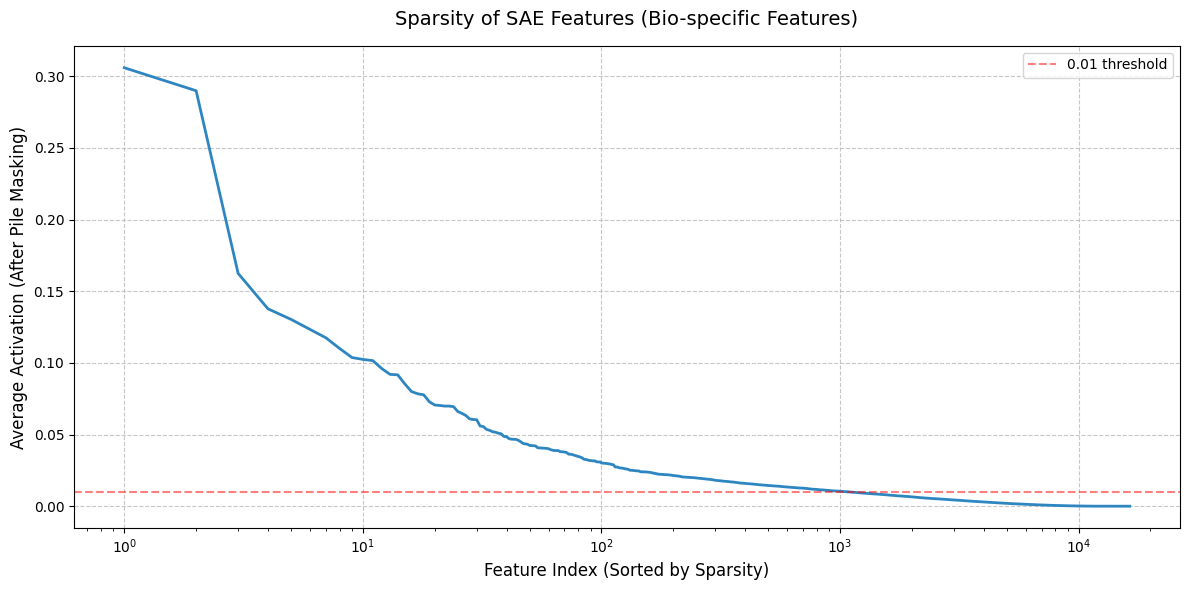

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(bio_sparsities_sorted.values) + 1), bio_sparsities_sorted.values, linewidth=2, color='#2E86C1')

plt.title('Sparsity of SAE Features (Bio-specific Features)', fontsize=14, pad=15)
plt.xlabel('Feature Index (Sorted by Sparsity)', fontsize=12)
plt.ylabel('Average Activation (After Pile Masking)', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
# plt.yscale('log')  # Log scale often helps visualize sparsity patterns better
plt.xscale('log')

# Add a horizontal line at 0.01 for reference
plt.axhline(y=0.01, color='r', linestyle='--', alpha=0.5, label='0.01 threshold')

plt.legend()
plt.tight_layout()

In [12]:
print(f"Layer {sae_layer}, {sae_type} SAE top features")
print(bio_sparsities_sorted.indices[:200])

Layer 21, 16k SAE top features
tensor([ 4946,  1013,  9879,  9715, 11463,  2006, 10496,  6620,  3300,  3179,
        10422, 14570,  1459,  7340, 12231,  3706,  6170,  7078, 11002, 11136,
        10307, 12443,  3823,  8465,  2811,  5079,  8824,  8627,  8834,    17,
         5202, 10639,  2708,  5193,  7194, 14384,   180,  3337,  7144,  7593,
        13671, 11279,  2632, 12450, 13344,  8455, 11588,  1074,  9437,  2275,
        10061,  9920,  4735, 14427,  9598,  9333,    18, 14221,  7290,  1274,
         9469,  6551,  4373,  7779, 10066,  7715,  4574,  6085,  3144, 13094,
         4887, 16215, 15849,  3275, 13529,  5062,   826,  7999,  6466, 13517,
         8387,  7879,  2222,  5702,  7151,  8647,  4640, 11196,  6356,  3313,
         5991,  9115,  1061,   929, 14946, 15078, 11452, 14235,  4817,  9467,
         9708,  4116, 14100, 13096, 13132, 16122,  4455,  9902, 12560, 11868,
         6321,  8441,  5134, 13876, 11575, 16349, 14716,  6043, 15040, 10524,
         9141, 13042, 12544,  155

### Visualize SAE Features

In [10]:
from IPython.display import IFrame
html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

# 'The idiotype network is experimentally modified to provide protective immunity against various microbial pathogens. Both internal and non-internal image-idiotype antibodies can trigger specific immune responses to antigens. The current outbreak of Severe Acute Respiratory Syndrome 2 (SARS-2) has provided a great opportunity to take advantage of idiotype / anti-idiotype antibodies as a protective regimen when no approved vaccine is available on earth. The current review identifies successful applications of idiotype/ anti-idiotype antibodies in various viral diseases and highlights their importance in COVID-19 pandemics. In the absence of vaccines and targeted therapies, polyclonal idiotype/ anti-idiotype antibodies against the viral structure may be a potential approach to the prevention and treatment of COVID-19 patients.'
 
sae_layer = 7
feature_idx = 11888
def get_dashboard_html(sae_release = "gemma-2-9b", sae_id=f"{sae_layer}-gemmascope-res-{sae_type}", feature_idx=0):
    return html_template.format(sae_release, sae_id, feature_idx)

html = get_dashboard_html(sae_release = "gemma-2-9b", sae_id=f"{sae_layer}-gemmascope-res-{sae_type}", feature_idx=feature_idx)
print(html)
IFrame(html, width=1200, height=600)

https://neuronpedia.org/gemma-2-9b/7-gemmascope-res-16k/11888?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300


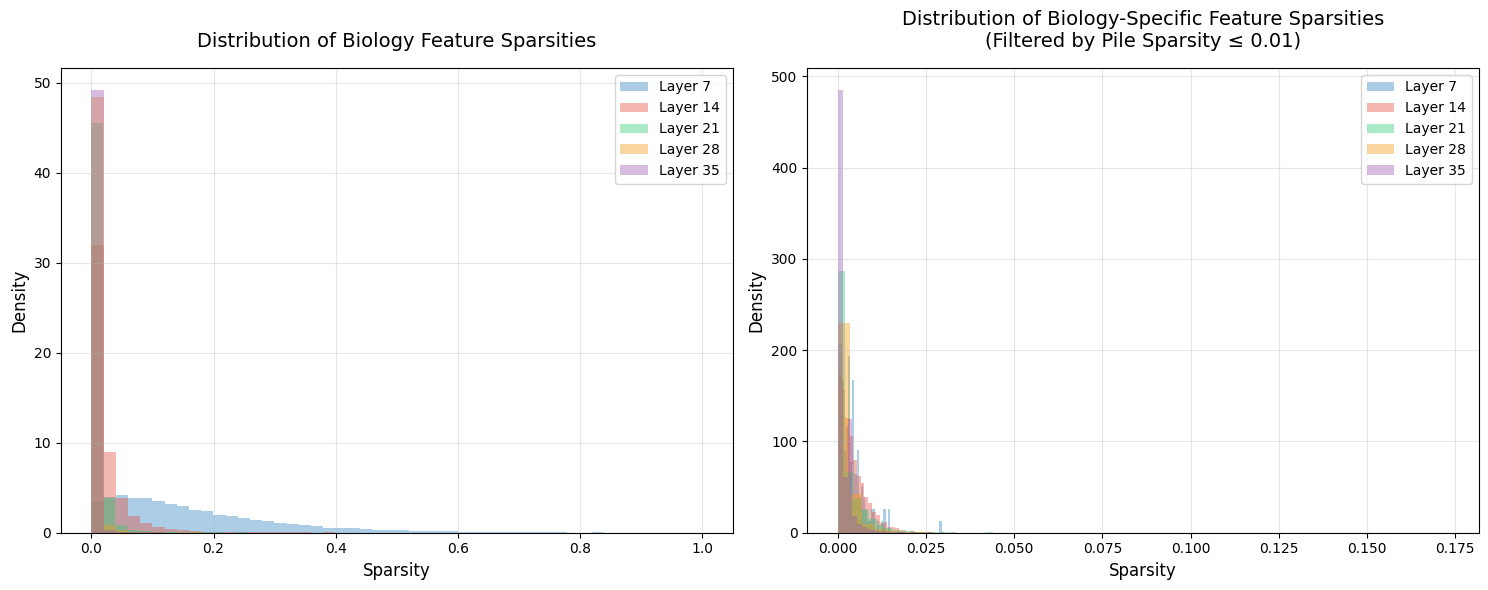

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define colors for different layers - using a color palette with 5 distinct colors
colors = ['#2E86C1', '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6']  # Blue, Red, Green, Orange, Purple
alphas = 0.4

# Plot 1: Raw biology sparsities
for layer, color in zip(sparsity_dfs.keys(), colors):
    sparsity_df = sparsity_dfs[layer]
    ax1.hist(sparsity_df["bio_sparsity"], bins=50, alpha=alphas, 
             color=color, label=f'Layer {layer}', density=True)

ax1.set_title('Distribution of Biology Feature Sparsities', fontsize=14, pad=15)
ax1.set_xlabel('Sparsity', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
# ax1.set_yscale('log')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Filtered biology sparsities
for layer, color in zip(sae_layers, colors):
    sparsity_df = sparsity_dfs[layer]
    filtered_bio_sparsity = np.where(sparsity_df["pile_sparsity"] <= 0.01, 1, 0) * sparsity_df["bio_sparsity"]
    # Only plot non-zero values
    filtered_bio_sparsity = filtered_bio_sparsity[filtered_bio_sparsity > 0]
    ax2.hist(filtered_bio_sparsity, bins=50, alpha=alphas, 
             color=color, label=f'Layer {layer}', density=True)

ax2.set_title('Distribution of Biology-Specific Feature Sparsities\n(Filtered by Pile Sparsity ≤ 0.01)', fontsize=14, pad=15)
ax2.set_xlabel('Sparsity', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
# ax2.set_yscale('log')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

### Filter Features for Bio-Relevant

In [14]:
import requests
import asyncio

generate_related_eval = False


if generate_related_eval:
    url = "https://www.neuronpedia.org/api/explanation/export"
    from openai import AsyncOpenAI
    import asyncio
    import time

    async_client = AsyncOpenAI(api_key=os.getenv("OPENROUTER_API_KEY"), base_url="https://openrouter.ai/api/v1")

    async def check_related(feature_description):
        response = await async_client.chat.completions.create(
            model="openai/gpt-4o-mini",
            messages=[{"role": "user", "content": f"Is the following description clearly and closely related to biology?\n{feature_description}\nRespond with one word, 'Yes' or 'No'."}],
            temperature=0
        )
        return "yes" in response.choices[0].message.content.lower()

    # with semaphore and rate limiting
    semaphore = asyncio.Semaphore(500)
    async def check_related_semaphore(explanation_df, feature_idx):
        async with semaphore:
            if feature_idx not in explanation_df.index:
                print(f"Feature {feature_idx} not found in explanation_df")
                return False
            result = await check_related(explanation_df.loc[feature_idx, "description"])
            # await asyncio.sleep(60)  # Wait 1 second after each request
            return result

    for sae_layer in tqdm(sparsity_dfs.keys()):
        headers = {"X-Api-Key": os.getenv("NEURONPEDIA_API_KEY")}
        params = {"modelId": "gemma-2-9b", "saeId": f"{sae_layer}-gemmascope-res-16k"}
        # params = {"modelId": "gpt2-small", "saeId": "6-res-jb"}

        response = requests.get(url, headers=headers, params=params)
        print(len(response.json()))
        explanations_df = pd.DataFrame(response.json())
        explanations_df["index"] = explanations_df["index"].astype(int)
        explanations_df = explanations_df.set_index("index").sort_index()

        sparsity_df = sparsity_dfs[sae_layer]
        filtered_bio_sparsity = np.where(sparsity_df["pile_sparsity"] <= 0.05, 1, 0) * sparsity_df["bio_sparsity"]
        features_sorted = filtered_bio_sparsity.sort_values(ascending=False)
        # features = features_sorted.head(1000).index.tolist()
        features = features_sorted[features_sorted > 0].index.tolist()

        print(f"Checking {len(features)} features for layer {sae_layer}")
        tasks = [check_related_semaphore(explanations_df, feature_idx) for feature_idx in features]
        results = await asyncio.gather(*tasks)
        print("Done checking")

        sparsity_dfs[sae_layer].loc[features, "bio_related"] = results

        sparsity_dfs[sae_layer].to_csv(f"saes/sparsity_dfs/{sae_type}_{sae_layer}.csv")

  0%|          | 0/5 [00:00<?, ?it/s]

16384
Checking 1969 features for layer 7
Done checking
16377
Checking 14617 features for layer 14
Feature 14287 not found in explanation_df
Feature 1964 not found in explanation_df
Feature 14349 not found in explanation_df
Feature 1865 not found in explanation_df
Feature 12543 not found in explanation_df
Done checking


/tmp/ipykernel_113851/2692201934.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, False, False, True, True, True, True, False, True, True, False, False, True, True, True, True, False, True, True, True, True, False, True, True, True, False, False, True, False, True, True, True, True, True, True, True, False, False, True, True, False, True, True, True, True, True, False, False, False, True, False, True, True, True, True, True, True, False, True, True, False, True, False, True, False, True, False, True, True, True, False, False, False, False, True, False, False, False, False, True, False, True, True, True, True, True, True, False, True, False, True, False, False, False, False

16381
Checking 16102 features for layer 21
Done checking


/tmp/ipykernel_113851/2692201934.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, False, True, True, False, True, True, True, True, True, True, False, True, True, True, False, False, True, True, False, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, False, True, True, True, True, False, True, True, True, False, False, False, False, True, True, True, True, False, True, True, True, False, True, True, True, False, True, True, False, False, True, True, True, True, True, True, False, False, False, True, True, False, False, False, False, True, True, False, False, T

16381
Checking 15179 features for layer 28
Feature 4864 not found in explanation_df
Feature 4264 not found in explanation_df
Feature 5975 not found in explanation_df
Done checking


/tmp/ipykernel_113851/2692201934.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, False, True, True, True, True, False, True, True, True, False, True, True, True, False, False, False, True, True, True, True, True, True, True, True, True, False, False, True, False, True, True, True, True, True, False, False, True, False, False, True, False, True, True, False, False, False, False, False, True, False, True, True, False, False, True, False, True, True, False, True, False, True, True, True, True, False, False, False, False, True, True, False, True, False, True, True, True, False, True, False, True, False, True, False, False, True, False, False, False, False, True, True, False, False, True, False, True, False, False, False, True, True, False, True, False, True, False, False, False, False, False, False, 

16384
Checking 11682 features for layer 35
Done checking


/tmp/ipykernel_113851/2692201934.py:55: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[True, False, True, True, False, False, False, False, True, False, True, False, False, True, False, False, False, False, False, True, True, False, True, True, True, True, True, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, True, False, False, False, False, True, False, False, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, True, False, False, True, False, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, True, False, True, True, False, True, False, False, False, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False, False, 

In [17]:
sparsity_dfs[7].query("bio_related == True or bio_related == False").sort_values("bio_sparsity", ascending=False)

,Unnamed: 0,pile_sparsity,bio_sparsity,bio_related
4261,4261,0.047469,0.125262,True
10408,10408,0.043982,0.123045,True
12812,12812,0.049178,0.104645,False
8581,8581,0.048302,0.103280,False
7789,7789,0.049835,0.099039,False
...,...,...,...,...
5318,5318,0.003077,0.000103,True
14289,14289,0.000190,0.000095,False
10962,10962,0.000298,0.000095,False
9505,9505,0.000567,0.000063,False


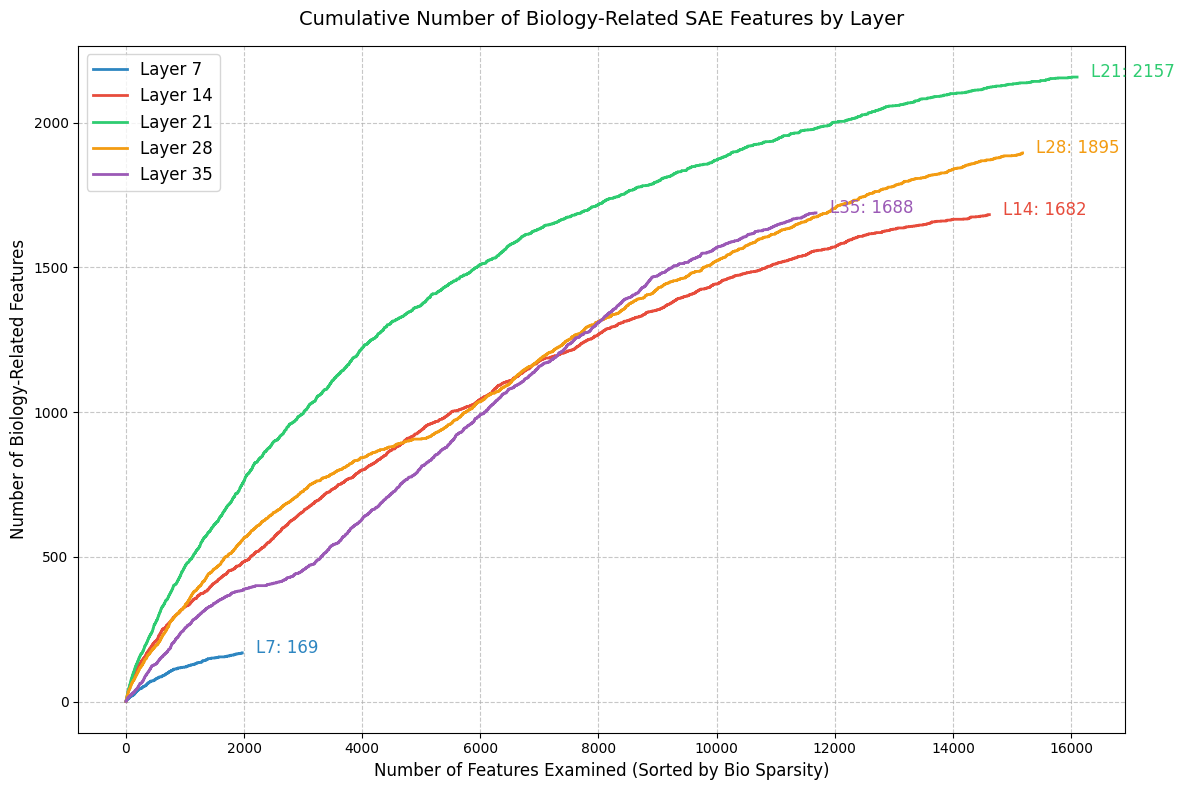

In [20]:
# Create cumulative sum plot for all layers
plt.figure(figsize=(12, 8))

# Colors for different layers
colors = ['#2E86C1', '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6']  # Blue, Red, Green, Orange, Purple

for sae_layer, color in zip(sparsity_dfs.keys(), colors):
    # Get sorted features and calculate cumsum for this layer
    sorted_features = sparsity_dfs[sae_layer].query("bio_related == True or bio_related == False").sort_values("bio_sparsity", ascending=False)
    cumsum = sorted_features["bio_related"].cumsum()
    
    # Plot line for this layer
    plt.plot(range(1, len(sorted_features) + 1), cumsum, '-', 
             color=color, 
             linewidth=2, 
             label=f'Layer {sae_layer}')
    
    # Add final count annotation
    plt.annotate(f'L{sae_layer}: {int(cumsum.iloc[-1])}', 
                xy=(len(sorted_features), cumsum.iloc[-1]),
                xytext=(10, 0),
                textcoords='offset points',
                fontsize=12,
                color=color)

plt.title('Cumulative Number of Biology-Related SAE Features by Layer', fontsize=14, pad=15)
plt.xlabel('Number of Features Examined (Sorted by Bio Sparsity)', fontsize=12)
plt.ylabel('Number of Biology-Related Features', fontsize=12)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(fontsize=12)

plt.tight_layout()

# Try Unlearning Approaches

## Clamp SAE Feature

### Try Clamping

In [10]:
def gather_residual_activations(model, target_layers, input_ids, attention_mask=None, unmasked_for_sae=False):
  output = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
  hidden_states = output.hidden_states
  # hidden state has n_layers + 1 elements, the first one is the embeddings
  # so need to add one to the target layer to get the correct layer
  if isinstance(target_layers, int):
    target_layers = [target_layers]

  layer_hidden_states = []
  for layer in target_layers:
    layer_hidden_states.append(hidden_states[layer+1])
  layer_hidden_states = torch.stack(layer_hidden_states)
  if unmasked_for_sae:
    assert attention_mask is not None, "Must provide attention mask for flat return"

    # layer hidden states should be shape (n_layers, batch_size, seq_len, hidden_size)
    # attention_mask should be shape (batch_size, seq_len)
    assert layer_hidden_states.shape[1] == attention_mask.shape[0], f"Batch size mismatch, {layer_hidden_states.shape} vs {attention_mask.shape}"
    assert layer_hidden_states.shape[2] == attention_mask.shape[1], f"Sequence length mismatch, {layer_hidden_states.shape} vs {attention_mask.shape}"
    assert len(layer_hidden_states.shape) == 4 and len(attention_mask.shape) == 2, f"Layer hidden states and attention mask must be 4D and 2D respectively but got {layer_hidden_states.shape} and {attention_mask.shape}"
    batch_indices, seq_indices = torch.where(attention_mask[:, 1:])
    layer_hidden_states = layer_hidden_states[:, :, 1:, :]
    return layer_hidden_states[:, batch_indices, seq_indices, :]

  else:
    return layer_hidden_states
    
batch = bio_ce_task.get_batch()["abstract"]
inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=200)
inputs = {k: v.cuda() for k, v in inputs.items()}
print(inputs["input_ids"].shape)
print(inputs["attention_mask"].sum())


with torch.no_grad():
    target_act = gather_residual_activations(model, 21, **inputs, unmasked_for_sae=True)[0]
print(target_act.shape)


sae = sae_dict[21]
if next(sae.parameters()).device.type != "cuda":
    sae = sae.cuda()
with torch.amp.autocast(device_type="cuda"):
    sae_acts = sae.encode(target_act)
print(sae_acts.shape)


recon = sae.decode(sae_acts)
with torch.no_grad():
    if len(sae_acts.shape) == 2:
        print(1 - torch.mean((recon - target_act.to(torch.float32)) **2) / (target_act.to(torch.float32).var()))
    else:
        print(1 - torch.mean((recon[..., 1:] - target_act[..., 1:].to(torch.float32)) **2) / (target_act[..., 1:].to(torch.float32).var()))

torch.Size([16, 200])
tensor(3198, device='cuda:0')
torch.Size([3182, 3584])
torch.Size([3182, 16384])
tensor(0.8986, device='cuda:0')


In [11]:
# calculate my own sae acts
import einops

with torch.no_grad():
    with torch.amp.autocast(device_type="cuda"):
        sae_acts_mine = einops.einsum(target_act, sae.W_enc, "batch hidden, hidden feature -> batch feature") + sae.b_enc
        sae_acts_mine = (sae_acts_mine > sae.threshold) * sae_acts_mine

    assert torch.allclose(sae_acts, sae_acts_mine, atol=1e-4)

    with torch.amp.autocast(device_type="cuda"):
        recon_mine = einops.einsum(sae_acts, sae.W_dec, "batch feature, feature hidden -> batch hidden") + sae.b_dec
    
    print((recon_mine - recon).abs().mean())
    # assert torch.allclose(recon_mine, recon, atol=1e-2), f"Reconstruction mismatch: {(recon_mine - recon).abs().mean()}"


tensor(0.0005, device='cuda:0')


In [12]:
feature = 4946
print((sae_acts[:, 4946] != 0).float().mean())

feature_w = sae.W_enc[:, feature]
feature_b = sae.b_enc[feature]
threshold = sae.threshold[feature]

with torch.no_grad():
    with torch.amp.autocast(device_type="cuda", dtype=torch.float32):
        feature_acts = einops.einsum(target_act, feature_w, "batch hidden, hidden -> batch") + feature_b
        print(feature_acts.shape)
        feature_acts = (feature_acts > threshold) * feature_acts
        print((feature_acts - sae_acts[:, feature]).abs().max())

    print((feature_acts - sae_acts[:, feature]).abs().max())

    # with torch.amp.autocast(device_type="cuda", dtype=torch.float32):
    #     recon_mine = einops.einsum(feature_acts, sae.W_dec, "batch, hidden -> batch hidden")
    # plt.scatter(feature_acts.cpu().float().detach().numpy(), sae_acts[:, feature].cpu().float().detach().numpy())


tensor(0.2555, device='cuda:0')
torch.Size([3182])
tensor(0.0164, device='cuda:0')
tensor(0.0164, device='cuda:0')


In [13]:
def clamp_sae_feature(act, sae, feature, clamp_value=0):
    feature_w = sae.W_enc[:, feature]
    feature_b = sae.b_enc[feature]
    threshold = sae.threshold[feature]
    feature_vec = sae.W_dec[feature]

    with torch.amp.autocast(device_type="cuda"):
        feature_acts = einops.einsum(act, feature_w, "batch hidden, hidden -> batch") + feature_b
        # feature_acts = (feature_acts > threshold) * feature_acts
        clamped_feature_diff = torch.where(feature_acts > threshold, clamp_value - feature_acts, 0)
    # if feature act is 0, then don't need to do anything
    # if feature act is positive, then need to clamp it: can replicate by subtracting (feature_acts - clamp_value) * feature_w_dec
    
    return act + einops.einsum(clamped_feature_diff, feature_vec, "batch, hidden -> batch hidden")

with torch.no_grad():
    clamped_recon = clamp_sae_feature(target_act, sae, feature, clamp_value=-1)



In [15]:
feature_clamped_acts = torch.where(sae_acts[:, feature] > 0, -1, 0)
sae_clamped_acts = sae_acts.clone()
sae_clamped_acts[:, feature] = feature_clamped_acts
real_clamped_recon = sae.decode(sae_clamped_acts)

print((clamped_recon - real_clamped_recon).var())

with torch.no_grad():
    if len(sae_acts.shape) == 2:
        print("R^2:", 1 - torch.mean((real_clamped_recon - clamped_recon) **2) / (real_clamped_recon.var()))
    # else:
    #     print(1 - torch.mean((recon[..., 1:] - target_act[..., 1:].to(torch.float32)) **2) / (target_act[..., 1:].to(torch.float32).var()))

tensor(2.1207, device='cuda:0', grad_fn=<VarBackward0>)
R^2: tensor(0.8868, device='cuda:0')


In [18]:
with torch.no_grad():
    diff_matrix = sae.decode(sae_acts) - sae.decode(sae_clamped_acts)
    print(diff_matrix)

    diff_matrix_nonzero = einops.rearrange(diff_matrix[diff_matrix != 0], "(batch hidden) -> batch hidden", hidden=diff_matrix.shape[-1])
    print(diff_matrix_nonzero.shape)
    U, S, V = torch.linalg.svd(diff_matrix_nonzero)
    print("Singular values:", S)
    print("\nShape of U:", U.shape)
    print("Shape of V:", V.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
torch.Size([813, 3584])
Singular values: tensor([4.8745e+02, 1.9114e-04, 5.6046e-05, 5.1033e-05, 4.5915e-05, 4.2692e-05,
        3.5979e-05, 3.5347e-05, 3.0093e-05, 2.6639e-05, 2.5648e-05, 2.5132e-05,
        2.4639e-05, 2.3818e-05, 2.3609e-05, 2.3454e-05, 2.2314e-05, 2.1965e-05,
        2.1932e-05, 2.1662e-05, 2.1378e-05, 2.1034e-05, 2.0549e-05, 2.0246e-05,
        2.0042e-05, 1.9841e-05, 1.9717e-05, 1.9244e-05, 1.9042e-05, 1.8864e-05,
        1.8620e-05, 1.8512e-05, 1.8337e-05, 1.8222e-05, 1.7830e-05, 1.7758e-05,
        1.7653e-05, 1.7437e-05, 1.7248e-05, 1.7215e-05, 1.7025e-05, 1.6820e-05,
        1.6609e-05, 1.6418e-05, 1.6410e-05, 1.6394e-05, 1.6250e-05, 1.5956e-05,
        1.5896e-05, 1.5797e-05, 1.5690e-05, 1.55

### Test Clamping

In [19]:
def clamp_sae_feature(act, sae, features, clamp_value=0):
    if isinstance(features, int):
        features = [features]
    feature_w = sae.W_enc[:, features] # [hidden, n_features]
    feature_b = sae.b_enc[features] # [n_features]
    threshold = sae.threshold[features] # [n_features]
    feature_vec = sae.W_dec[features] # [n_features, hidden]

    # print(f"{feature_w.shape=}, {feature_b.shape=}, {threshold.shape=}, {feature_vec.shape=}, {act.shape=}")

    with torch.amp.autocast(device_type="cuda", dtype=dtype):
        feature_acts = einops.einsum(act, feature_w, "... hidden, hidden n_features -> ... n_features") + feature_b
        # print(f"{feature_acts.shape=}")
        # feature_acts = (feature_acts > threshold) * feature_acts
        clamped_feature_diff = torch.where(feature_acts > threshold, clamp_value - feature_acts, 0)
        # print(f"{clamped_feature_diff.shape=}")
    # if feature act is 0, then don't need to do anything
    # if feature act is positive, then need to clamp it: can replicate by subtracting (feature_acts - clamp_value) * feature_w_dec
        output = act + einops.einsum(clamped_feature_diff, feature_vec, "... n_features, n_features hidden -> ... hidden")
    return output

def clamp_sae_feature_decode(act, sae, features, clamp_value=0):
    sae_acts = sae.encode(act)
    if isinstance(features, int):
        features = [features]
    # print(f"{sae_acts.shape=}")
    # print(f"{sae_acts[..., features]=}")
    with torch.amp.autocast(device_type="cuda", dtype=dtype):
        feature_clamped_acts = torch.where(sae_acts[..., features] > 0, clamp_value, 0.)
        sae_acts[..., features] = feature_clamped_acts
        output = sae.decode(sae_acts).to(dtype)
    return output

def get_hook(sae, features, clamp_value=0, decode=False):
    def clamp_hook(module, inputs, output):
        if decode:
            new_output = (clamp_sae_feature_decode(output[0], sae, features, clamp_value=clamp_value),) + output[1:]
        else:
            new_output = (clamp_sae_feature(output[0], sae, features, clamp_value=clamp_value),) + output[1:]
        return new_output
    return clamp_hook

@contextlib.contextmanager
def temporary_forward_hook(module, hook_fn):
    """
    Registers the given hook function to `module` and removes it on exit.
    """
    handle = module.register_forward_hook(hook_fn)
    try:
        yield
    finally:
        handle.remove()


#### Clamp One Feature

In [22]:
feature_idx = 4946
clamp_value = -100



sae = sae_dict[21]
if next(sae.parameters()).device.type != "cuda":
    sae = sae.cuda()

# For a GPT2-like model
inputs = tokenizer("A submicroscopic particle that can only replicate in a organism's living cells is called a", return_tensors="pt", padding=True, truncation=True, max_length=200)
inputs = {k: v.cuda() for k, v in inputs.items()}
with torch.no_grad():
    output = model(**inputs)
print(tokenizer.batch_decode(output.logits.argmax(dim=-1).cpu().numpy().squeeze()))

layer_module = model.model.layers[sae_layer]
with temporary_forward_hook(layer_module, get_hook(sae, feature_idx, clamp_value=-100)):
    inputs = tokenizer("A submicroscopic particle that can only replicate in a organism's living cells is called a", return_tensors="pt", padding=True, truncation=True, max_length=200)
    inputs = {k: v.cuda() for k, v in inputs.items()}
    with torch.no_grad():
        output = model(**inputs)
    print(tokenizer.batch_decode(output.logits.argmax(dim=-1).cpu().numpy().squeeze()))

['<h1>', ' ', '-', 'roscopic', ' particle', ' of', ' is', ' be', ' be', ' inside', ' a', ' living', ' is', 's', ' cells', ' cells', ' is', ' called', ' a', ' virus']
['<h1>', ' ', '-', 'roscopic', ' particle', ' of', ' is', ' be', ' be', ' inside', ' a', ' living', ' is', 's', ' cell', ' cells', ' is', ' called', ' a', ' virus']


In [23]:
from tasks.general_capabilities.MCTask_redo import run_general_evals
clamp_value = -100
sae_layer = 21
layer_module = model.model.layers[sae_layer]
feature_indices = [ 4946,  1013,  9879, 11463,  9715,  3300,  3179,  2006, 10496,  1459,
         6620, 12231,  7340, 14570, 10422,  3706,  8465,  6170,    17, 11002]


# print("Approximate clamping (simulating effect of clamping feature)")
# with temporary_forward_hook(layer_module, get_hook(sae, feature_indices, clamp_value=clamp_value)):
#     accuracy = bio_mc_task.get_test_accuracy(model, num_iters=num_iters)
#     print(f"Accuracy: {accuracy}")

#     mmlu = run_general_evals(model, model_type=model_type, evals_to_include=["MMLU"], verbose=True, batch_size=5, device="cuda")
#     print(mmlu)

print("Full clamping (clamping fully calculated feature, and returning SAE-decoded output)")
with temporary_forward_hook(layer_module, get_hook(sae, feature_indices, clamp_value=clamp_value, decode=True)):
    accuracy = bio_mc_task.get_test_accuracy(model, num_iters=num_iters)
    print(f"Accuracy: {accuracy}")

    mmlu = run_general_evals(model, model_type=model_type, evals_to_include=["MMLU"], verbose=True, batch_size=5, device="cuda")
    print(mmlu)


Full clamping (clamping fully calculated feature, and returning SAE-decoded output)
Accuracy: 0.556874121291728


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU accuracy is 0.5900000000000001
{'MMLU': 0.5900000000000001}


#### Graph of Clamping Features

In [24]:
from tqdm.auto import tqdm
import pandas as pd
import itertools

# Define parameter space
decode_values = [True, False]
sae_layers = [7, 21, 35]
# n_feature_options = [10, 20, 50, 200, 1000]
n_feature_options = [10, 50, 200, 1000]
clamp_values = [0, -1, -10, -100, -1000]

# Create iterator for all combinations
total_combinations = len(decode_values) * len(sae_layers) * len(n_feature_options) * len(clamp_values)

# Initialize results list to store dictionaries
results_list = []

# Create progress bar
pbar = tqdm(total=total_combinations, desc="Testing combinations")

for sae_layer in sae_layers:
    layer_module = model.model.layers[sae_layer]
    sae = sae_dict[sae_layer]
    if next(sae.parameters()).device.type != "cuda":
        sae = sae.cuda()

    param_iterator = itertools.product(
        decode_values,
        # sae_layers,
        n_feature_options,
        clamp_values
    )
    for decode, n_features, clamp_value in param_iterator:            
        # Get sparsity data for this layer
        sparsity_df = sparsity_dfs[sae_layer]
        filtered_bio_sparsity = np.where(sparsity_df["pile_sparsity"] <= 0.01, 1, 0) * sparsity_df["bio_sparsity"]
        features_sorted = filtered_bio_sparsity.sort_values(ascending=False)
        features = features_sorted.head(n_features).index.tolist()
        
        pbar.set_description(f"Layer {sae_layer}: Testing {n_features} features, clamp={clamp_value}, decode={decode}")
        
        with temporary_forward_hook(layer_module, get_hook(sae, features, clamp_value=clamp_value, decode=decode)):
            bio_accuracy = bio_mc_task.get_test_accuracy(model, num_iters=num_iters)
            mmlu = run_general_evals(model, model_type=model_type, evals_to_include=["MMLU"], verbose=False, batch_size=5, device="cuda")["MMLU"]
            
            # Store results in list
            results_list.append({
                'decode': decode,
                'layer': sae_layer,
                'n_features': n_features,
                'clamp_value': clamp_value,
                'bio_accuracy': bio_accuracy,
                'mmlu': mmlu
            })
            
            # Print current result
            print(f"\nResults for layer {sae_layer}, {n_features} features, clamp={clamp_value}, decode={decode}:")
            print(f"Bio accuracy: {bio_accuracy:.3f}")
            print(f"MMLU: {mmlu:.3f}")
        
        pbar.update(1)
    # Move SAE back to CPU after finishing with this layer
    sae = sae.cpu()

pbar.close()

# Convert results to DataFrame
results_df = pd.DataFrame(results_list)

display(results_df)

Testing combinations:   0%|          | 0/120 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=0, decode=True:
Bio accuracy: 0.600
MMLU: 0.660


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=-1, decode=True:
Bio accuracy: 0.598
MMLU: 0.660


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=-10, decode=True:
Bio accuracy: 0.587
MMLU: 0.660


KeyboardInterrupt: 

In [15]:
results_df.to_csv("sae_unlearning_results.csv", index=False)

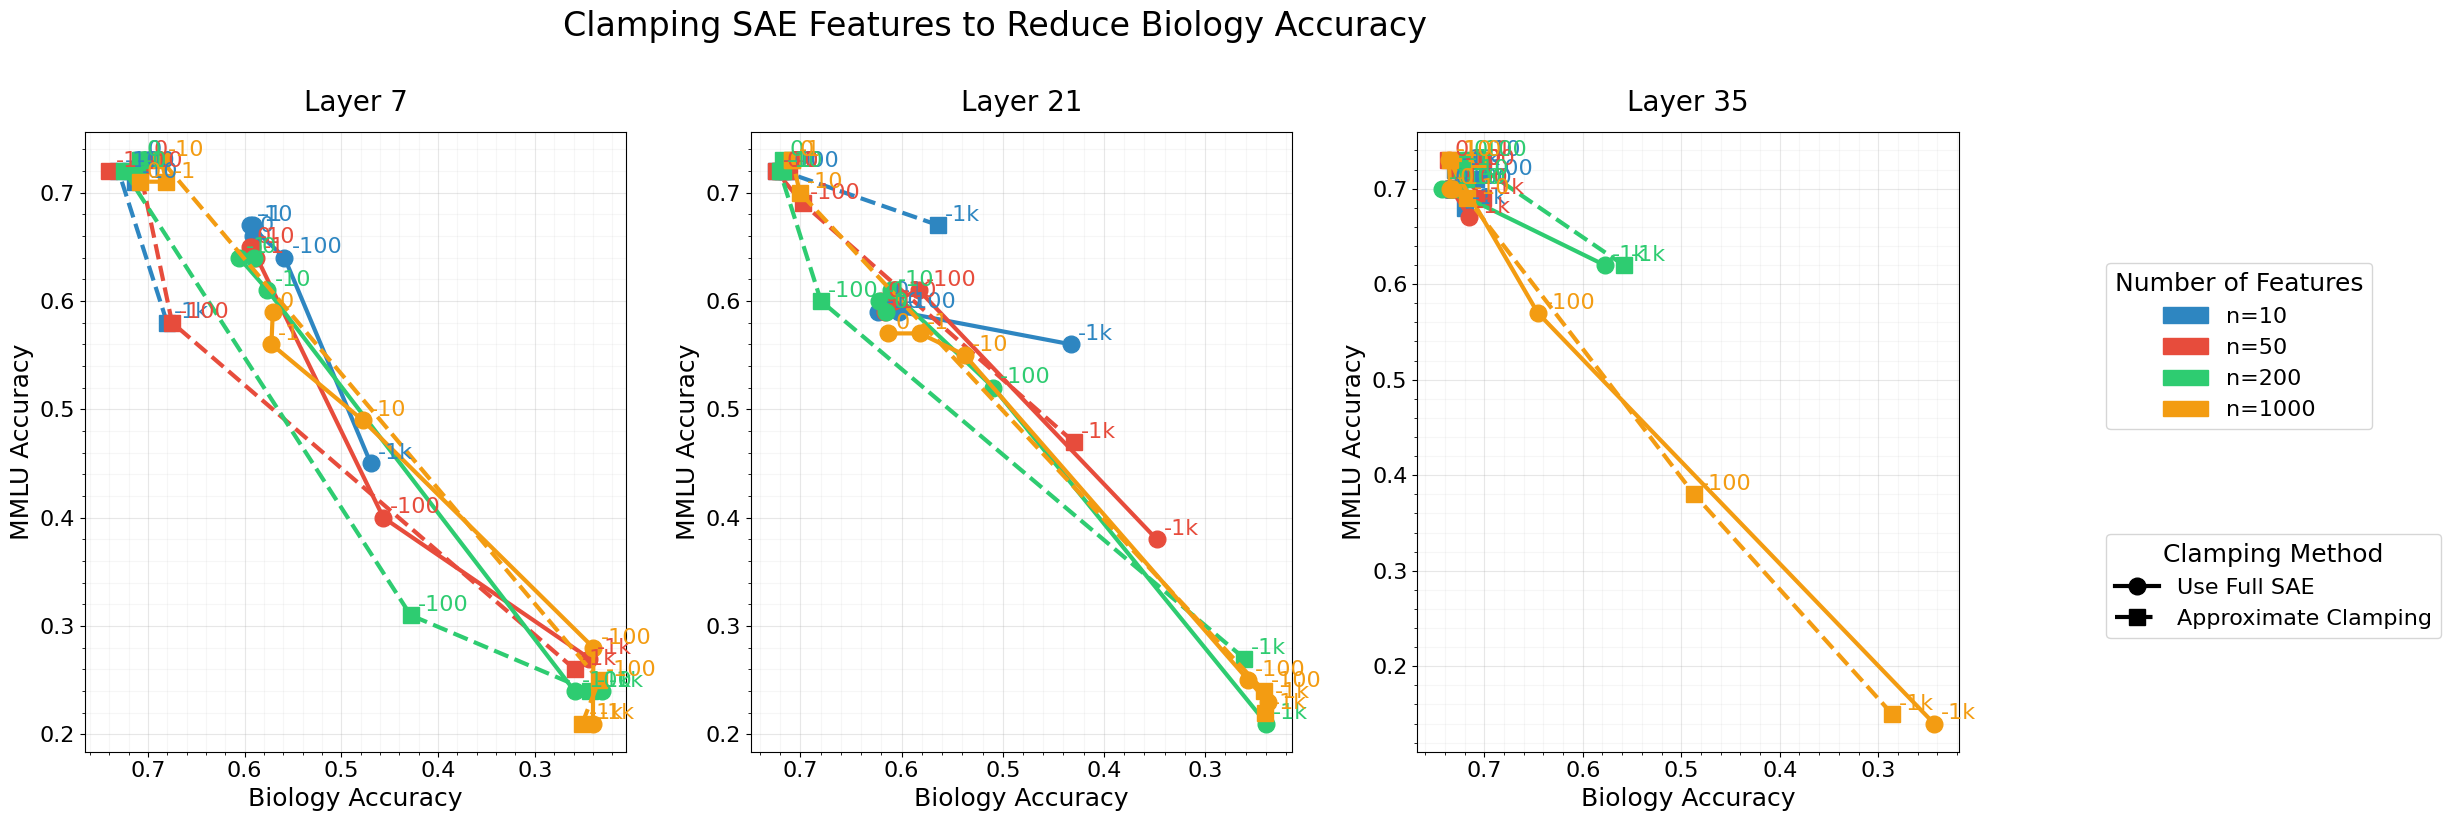

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Set style and figure size
plt.figure(figsize=(20, 8))

# Define colors for different n_features - using a custom color palette
colors = ['#2E86C1', '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6']  # Blue, Red, Green, Orange, Purple
n_features_unique = sorted(results_df['n_features'].unique())

# Define styles for decode True/False - increased sizes
decode_styles = {
    True: {'linestyle': '-', 'marker': 'o', 'markersize': 12, 'linewidth': 3},
    False: {'linestyle': '--', 'marker': 's', 'markersize': 12, 'linewidth': 3}
}

# Plot for each layer
for layer_idx, layer in enumerate(results_df['layer'].unique()):
    plt.subplot(1, len(results_df['layer'].unique()), layer_idx + 1)
    
    # Plot for each combination of n_features and decode
    for n_feat, color in zip(n_features_unique, colors):
        for decode in [True, False]:
            # Filter data
            mask = (results_df['layer'] == layer) & \
                  (results_df['n_features'] == n_feat) & \
                  (results_df['decode'] == decode)
            data = results_df[mask].sort_values('clamp_value')
            
            # Plot line and points without labels (we'll create custom legend)
            plt.plot(data['bio_accuracy'], data['mmlu'], 
                    color=color,
                    **decode_styles[decode])
            # Add clamp value annotations
            for _, row in data.iterrows():
                # Format clamp value text
                if row['clamp_value'] == 0:
                    clamp_text = '0'
                elif abs(row['clamp_value']) >= 1000:
                    clamp_text = f'{int(row["clamp_value"]/1000)}k'
                else:
                    clamp_text = str(int(row['clamp_value']))
                
                # Position text with small offset
                plt.annotate(clamp_text,
                           (row['bio_accuracy'], row['mmlu']),
                           xytext=(5, 3), textcoords='offset points',
                           fontsize=16, color=color)


    # plt.title(f'Clamping SAE Features from Layer {layer} to Reduce Bio Accuracy', fontsize=20, pad=15)
    plt.title(f'Layer {layer}', fontsize=20, pad=15)
    plt.xlabel('Biology Accuracy', fontsize=18)
    plt.ylabel('MMLU Accuracy', fontsize=18)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    # Reverse x-axis
    plt.gca().invert_xaxis()
    
    # Add minor gridlines
    plt.grid(True, which='minor', alpha=0.1)
    plt.minorticks_on()

plt.suptitle("Clamping SAE Features to Reduce Biology Accuracy", fontsize=24, y=1.02)
# Create custom legend
# First create the feature count legend handles
feature_handles = [mpatches.Patch(color=color, label=f'n={n_feat}') 
                  for color, n_feat in zip(colors, n_features_unique)]

# Create the decode type legend handles (in black)
decode_handles = [
    plt.Line2D([0], [0], color='black', linestyle='-', marker='o', markersize=12, linewidth=3, label='Use Full SAE'),
    plt.Line2D([0], [0], color='black', linestyle='--', marker='s', markersize=12, linewidth=3, label='Approximate Clamping')
]

# Add two separate legends
# Feature count legend
plt.figlegend(handles=feature_handles, 
              loc='center left',
              bbox_to_anchor=(1.05, 0.6),
              title='Number of Features',
              fontsize=16,
              title_fontsize=18)

# Decode type legend
plt.figlegend(handles=decode_handles,
              loc='center left',
              bbox_to_anchor=(1.05, 0.3),
              title='Clamping Method',
              fontsize=16,
              title_fontsize=18)

# Adjust layout to prevent text overlap
plt.tight_layout()

### Clamp Bio-Related Features

In [27]:
from tqdm.auto import tqdm
import pandas as pd
import itertools

# Define parameter space
decode_values = [True, False]
sae_layers = [7, 21, 28]
# n_feature_options = [10, 20, 50, 200, 1000]
n_feature_options = [10, 20, 50, 200]
clamp_values = [0, -1, -10, -100, -1000]

pile_clamp_thresholds = {7: 0.05, 21: 0.03, 35: 0.01}

# Create iterator for all combinations
total_combinations = len(decode_values) * len(sae_layers) * len(n_feature_options) * len(clamp_values)

# Initialize results list to store dictionaries
results_list = []

# Create progress bar
pbar = tqdm(total=total_combinations, desc="Testing combinations")

for sae_layer in sae_layers:
    layer_module = model.model.layers[sae_layer]
    sae = sae_dict[sae_layer]
    if next(sae.parameters()).device.type != "cuda":
        sae = sae.cuda()

    param_iterator = itertools.product(
        decode_values,
        # sae_layers,
        n_feature_options,
        clamp_values
    )
    for decode, n_features, clamp_value in param_iterator:            
        # Get sparsity data for this layer
        sparsity_df = sparsity_dfs[sae_layer]
        filtered_bio_sparsity = np.where(sparsity_df["pile_sparsity"] <= pile_clamp_thresholds[sae_layer], 1, 0) * sparsity_df["bio_sparsity"] * sparsity_df["bio_related"]
        features_sorted = filtered_bio_sparsity.sort_values(ascending=False)
        features = features_sorted.head(n_features).index.tolist()
        
        pbar.set_description(f"Layer {sae_layer}: Testing {n_features} features, clamp={clamp_value}, decode={decode}")
        
        with temporary_forward_hook(layer_module, get_hook(sae, features, clamp_value=clamp_value, decode=decode)):
            bio_accuracy = bio_mc_task.get_test_accuracy(model, num_iters=num_iters)
            mmlu = run_general_evals(model, model_type=model_type, evals_to_include=["MMLU"], verbose=False, batch_size=5, device="cuda")["MMLU"]
            
            # Store results in list
            results_list.append({
                'decode': decode,
                'layer': sae_layer,
                'n_features': n_features,
                'clamp_value': clamp_value,
                'bio_accuracy': bio_accuracy,
                'mmlu': mmlu
            })
            
            # Print current result
            print(f"\nResults for layer {sae_layer}, {n_features} features, clamp={clamp_value}, decode={decode}:")
            print(f"Bio accuracy: {bio_accuracy:.3f}")
            print(f"MMLU: {mmlu:.3f}")
        
        pbar.update(1)
    # Move SAE back to CPU after finishing with this layer
    sae = sae.cpu()

pbar.close()

# Convert results to DataFrame
results_df = pd.DataFrame(results_list)

display(results_df)

results_df.to_csv("sae_bio_related_unlearning_results.csv", index=False)

Testing combinations:   0%|          | 0/120 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=0, decode=True:
Bio accuracy: 0.590
MMLU: 0.650


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=-1, decode=True:
Bio accuracy: 0.592
MMLU: 0.650


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=-10, decode=True:
Bio accuracy: 0.581
MMLU: 0.660


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=-100, decode=True:
Bio accuracy: 0.457
MMLU: 0.530


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 10 features, clamp=-1000, decode=True:
Bio accuracy: 0.299
MMLU: 0.300


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Results for layer 7, 20 features, clamp=0, decode=True:
Bio accuracy: 0.599
MMLU: 0.640


KeyboardInterrupt: 

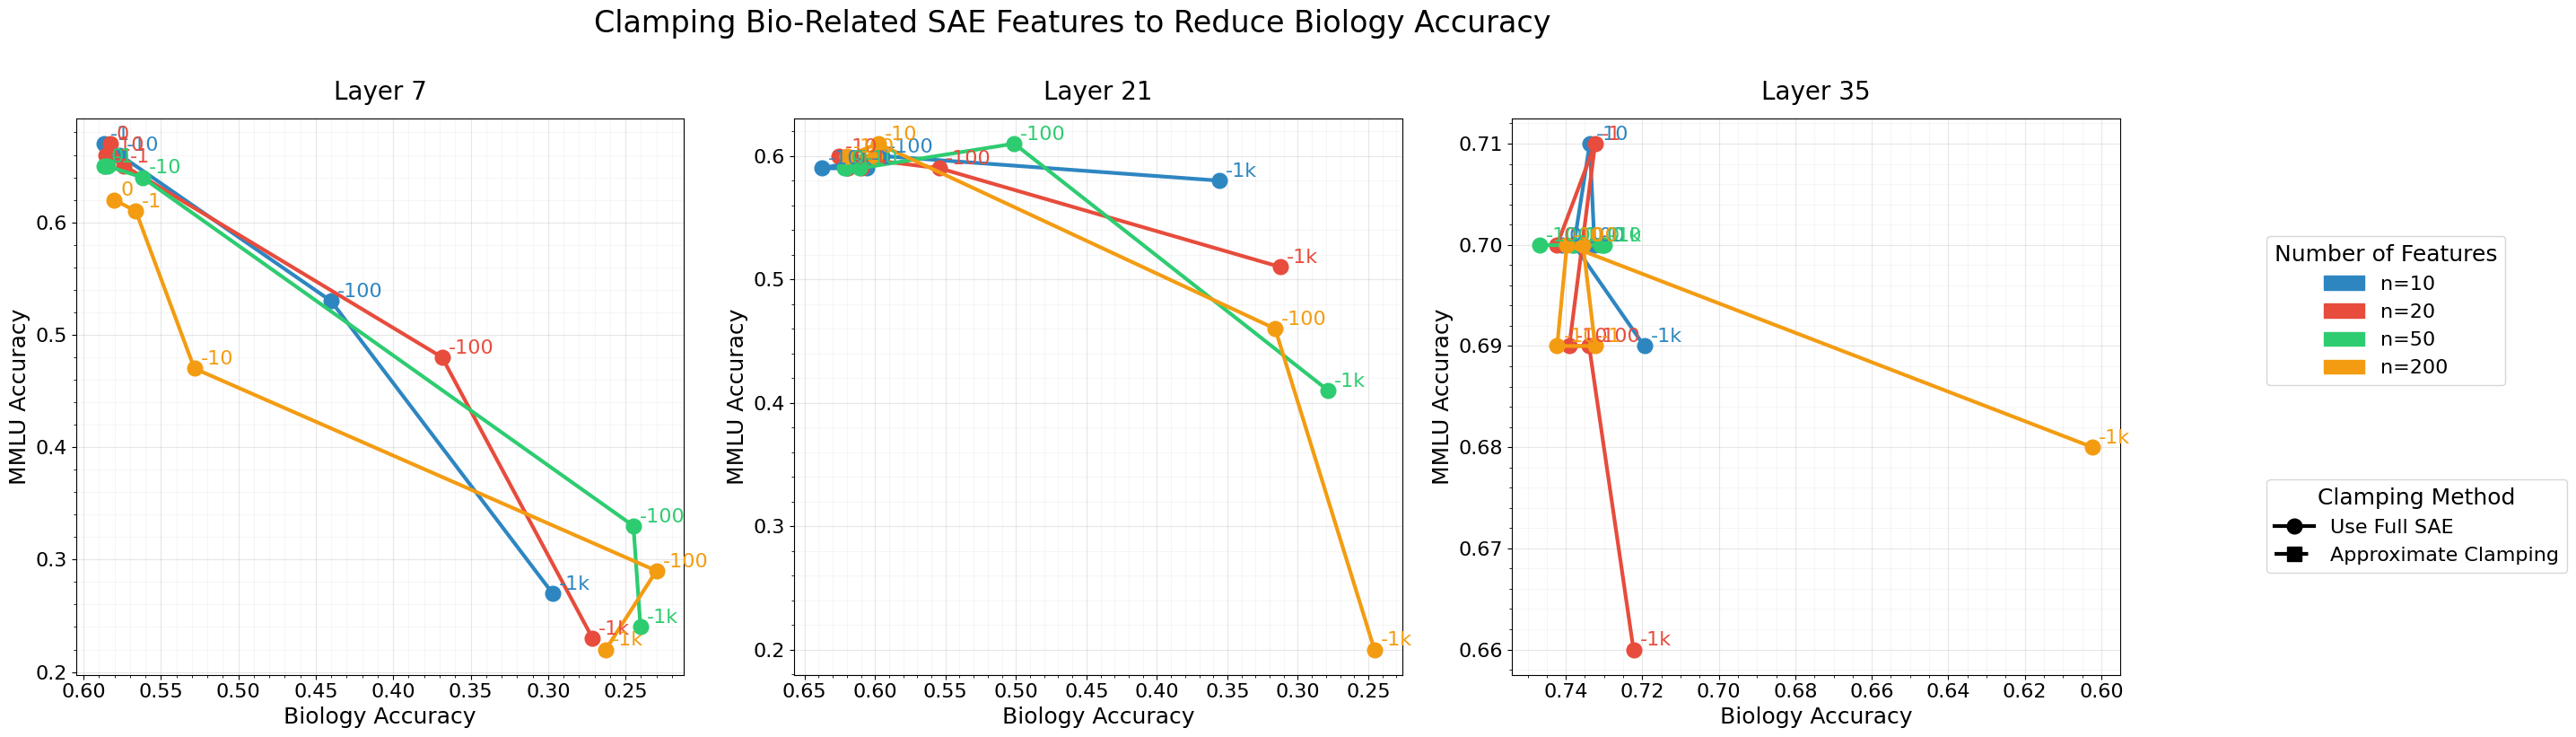

In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Set style and figure size
plt.figure(figsize=(8*len(results_df['layer'].unique()), 8))

# Define colors for different n_features - using a custom color palette
colors = ['#2E86C1', '#E74C3C', '#2ECC71', '#F39C12', '#9B59B6']  # Blue, Red, Green, Orange, Purple
n_features_unique = sorted(results_df['n_features'].unique())

# Define styles for decode True/False - increased sizes
decode_styles = {
    True: {'linestyle': '-', 'marker': 'o', 'markersize': 12, 'linewidth': 3},
    False: {'linestyle': '--', 'marker': 's', 'markersize': 12, 'linewidth': 3}
}

# Plot for each layer
for layer_idx, layer in enumerate(results_df['layer'].unique()):
    plt.subplot(1, len(results_df['layer'].unique()), layer_idx + 1)
    
    # Plot for each combination of n_features and decode
    for n_feat, color in zip(n_features_unique, colors):
        for decode in [True, False]:
            # Filter data
            mask = (results_df['layer'] == layer) & \
                  (results_df['n_features'] == n_feat) & \
                  (results_df['decode'] == decode)
            data = results_df[mask].sort_values('clamp_value')
            
            # Plot line and points without labels (we'll create custom legend)
            plt.plot(data['bio_accuracy'], data['mmlu'], 
                    color=color,
                    **decode_styles[decode])
            # Add clamp value annotations
            for _, row in data.iterrows():
                # Format clamp value text
                if row['clamp_value'] == 0:
                    clamp_text = '0'
                elif abs(row['clamp_value']) >= 1000:
                    clamp_text = f'{int(row["clamp_value"]/1000)}k'
                else:
                    clamp_text = str(int(row['clamp_value']))
                
                # Position text with small offset
                plt.annotate(clamp_text,
                           (row['bio_accuracy'], row['mmlu']),
                           xytext=(5, 3), textcoords='offset points',
                           fontsize=16, color=color)


    # plt.title(f'Clamping SAE Features from Layer {layer} to Reduce Bio Accuracy', fontsize=20, pad=15)
    plt.title(f'Layer {layer}', fontsize=20, pad=15)
    plt.xlabel('Biology Accuracy', fontsize=18)
    plt.ylabel('MMLU Accuracy', fontsize=18)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    # Reverse x-axis
    plt.gca().invert_xaxis()
    
    # Add minor gridlines
    plt.grid(True, which='minor', alpha=0.1)
    plt.minorticks_on()

plt.suptitle("Clamping Bio-Related SAE Features to Reduce Biology Accuracy", fontsize=24, y=1.02)
# Create custom legend
# First create the feature count legend handles
feature_handles = [mpatches.Patch(color=color, label=f'n={n_feat}') 
                  for color, n_feat in zip(colors, n_features_unique)]

# Create the decode type legend handles (in black)
decode_handles = [
    plt.Line2D([0], [0], color='black', linestyle='-', marker='o', markersize=12, linewidth=3, label='Use Full SAE'),
    plt.Line2D([0], [0], color='black', linestyle='--', marker='s', markersize=12, linewidth=3, label='Approximate Clamping')
]

# Add two separate legends
# Feature count legend
plt.figlegend(handles=feature_handles, 
              loc='center left',
              bbox_to_anchor=(1.05, 0.6),
              title='Number of Features',
              fontsize=16,
              title_fontsize=18)

# Decode type legend
plt.figlegend(handles=decode_handles,
              loc='center left',
              bbox_to_anchor=(1.05, 0.3),
              title='Clamping Method',
              fontsize=16,
              title_fontsize=18)

# Adjust layout to prevent text overlap
plt.tight_layout()

# Gradient Update Unlearning

In [8]:
# set up dataset
batch_size = 2

ctx_len = 100
bio_ce_task = WMDP_RelearnTask(batch_size=batch_size, tokenizer=tokenizer, corpus="bio-forget", shuffle=True, ctx_length=ctx_len)
display(bio_ce_task.dataset)

from tasks.general.DatasetTasks import PileTask
pile_task = PileTask(batch_size=batch_size, tokenizer=tokenizer, stream_dataset=True, buffer_size=10000, ctx_length=ctx_len)
print(pile_task.get_batch())

Dataset({
    features: ['title', 'abstract', 'text', 'doi'],
    num_rows: 24453
})

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

No test dataset available. Using train dataset for testing.
{'text': ['It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playing on the web works, but you have to simulate multi-touch for table moving and that can be a bit confusing.\n\nThere’s a lot I’d like to talk about. I’ll go through every topic, insted of making the typical what went right/wrong list.\n\nConcept\n\nWorking over the theme was probably one of the hardest tasks I had to face.\n\nOriginally, I had an idea of what kind of game I wanted to develop, gameplay wise – something with lots of enemies/actors, simple graphics, maybe set in space, controlled from a top-down view. I was confident I could fit any theme around it.\n\nIn the end, the problem with a theme like “Evolution” in a game is that evolution is unassisted. It happens through several seemingly random mutations over time, with the most apt permutation surviving. This genetic car simulator is, in my opinion, a great

In [9]:
from collections import defaultdict, deque

class ActivationDataset:
    def __init__(self, task_dict, original_model, activation_layers, number_buffer_batches=128, tokenizer=left_tokenizer, text_cols=None, max_length=500, store_in_cpu=True, keep_model_cpu=False, refresh_dict=None):
        """
        activation_layers: 0-indexed list of layers to store activations from

        keep_model_cpu: if True, keep the model in CPU memory (so send to cuda on refresh and send back)
        refresh_dict: if not None, a dictionary of task name to boolean which is True or False, if True the task's activations will be refreshed
        """
        self.original_model = original_model
        self.activation_layers = activation_layers
        self.number_buffer_batches = number_buffer_batches
        self.buffer = defaultdict(deque)
        self.task_dict = task_dict
        self.tokenizer = tokenizer
        if text_cols is None:
            text_cols = "text"
        if isinstance(text_cols, str):
            self.text_cols = {task_name: text_cols for task_name in task_dict.keys()}
        else:
            self.text_cols = text_cols
        self.max_length = max_length
        self.store_in_cpu = store_in_cpu
        self.keep_model_cpu = keep_model_cpu
        self.refresh_dict = refresh_dict

    def __iter__(self):
        return self
        
    def __next__(self):
        # If any buffer is empty, refresh all buffers
        if any(len(self.buffer[task_name]) == 0 for task_name in self.task_dict.keys()):
            self.refresh()
            
        # Pop one batch from each task's buffer
        try:
            batch = {
                task_name: self.buffer[task_name].popleft() 
                for task_name in self.task_dict.keys()
            }
            return batch
        except IndexError:
            raise StopIteration("Buffer is empty, probably a bug since this should have been refreshed?")

    def refresh(self):
        print("Refreshing buffer")
        self.original_model.cuda()

        # Clear existing buffers
        for task_name in self.task_dict.keys():
            if len(self.buffer[task_name]) > 0:
                print(f"Clearing nonempty buffer for {task_name}, current len: {len(self.buffer[task_name])}")
            self.buffer[task_name].clear()

        # for each task, get number_buffer_batches batches, get input_ids and attention_mask
        for task_name, task in self.task_dict.items():
            for i in range(self.number_buffer_batches):
                # print(f"{torch.cuda.memory_allocated() / 1024 ** 3} GB allocated")
                batch_text = task.get_batch()[self.text_cols[task_name]]
                tokenized = self.tokenizer(batch_text, return_tensors="pt", padding=True, truncation=True, max_length=self.max_length)
                input_ids = tokenized["input_ids"].cuda()
                attention_mask = tokenized["attention_mask"].cuda()
                if self.refresh_dict is not None and self.refresh_dict[task_name]:
                    with torch.no_grad():
                        original_output = self.original_model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
                        if self.store_in_cpu:
                            original_acts = {layer: original_output.hidden_states[layer+1].cpu() for layer in self.activation_layers}
                        else:
                            original_acts = {layer: original_output.hidden_states[layer+1] for layer in self.activation_layers}

                    if self.store_in_cpu:
                        self.buffer[task_name].append({"input_ids": input_ids.cpu(), "attention_mask": attention_mask.cpu(), "activations": original_acts})
                    else:
                        self.buffer[task_name].append({"input_ids": input_ids, "attention_mask": attention_mask, "activations": original_acts})
                else:
                    self.buffer[task_name].append({"input_ids": input_ids, "attention_mask": attention_mask})

        # add number_buffer_batches to the buffer
        if self.keep_model_cpu:
            self.original_model.cpu()
        print("Buffer refreshed")


activation_layers = [7, 21]



## RMU/Circuit Breakers

In [10]:
lora = False

if pretrained_path is not None:
    train_model = AutoModelForCausalLM.from_pretrained(pretrained_path, torch_dtype=dtype)
else:
    train_model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=dtype)
train_model.cuda()
model.eval()
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Turning off grads for {name} in original model")
        param.requires_grad = False

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Turning off grads for model.embed_tokens.weight in original model
Turning off grads for model.layers.0.self_attn.q_proj.weight in original model
Turning off grads for model.layers.0.self_attn.k_proj.weight in original model
Turning off grads for model.layers.0.self_attn.v_proj.weight in original model
Turning off grads for model.layers.0.self_attn.o_proj.weight in original model
Turning off grads for model.layers.0.mlp.gate_proj.weight in original model
Turning off grads for model.layers.0.mlp.up_proj.weight in original model
Turning off grads for model.layers.0.mlp.down_proj.weight in original model
Turning off grads for model.layers.0.input_layernorm.weight in original model
Turning off grads for model.layers.0.post_attention_layernorm.weight in original model
Turning off grads for model.layers.0.pre_feedforward_layernorm.weight in original model
Turning off grads for model.layers.0.post_feedforward_layernorm.weight in original model
Turning off grads for model.layers.1.self_attn.q_p

In [11]:
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
layers_to_transform = list(range(22))
if lora:
    config = LoraConfig(
        r=16,
        target_modules=["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "down_proj", "up_proj"],
        layers_to_transform=layers_to_transform,
        lora_alpha=16,
        lora_dropout=0.05
    )
    train_model = get_peft_model(train_model, config)

    learning_rate = 1e-4

else:
    for layer in range(n_layers):
        if layer in layers_to_transform:
            for param in train_model.model.layers[layer].parameters():
                param.requires_grad = True
        else:
            for param in train_model.model.layers[layer].parameters():
                param.requires_grad = False

    learning_rate = 2e-5

# how many trainable parameters?
trainable_params = 0
for name, param in train_model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)
        trainable_params += param.numel()
print(f"Number of trainable parameters: {trainable_params / 1e9} billion")


model.embed_tokens.weight torch.Size([256000, 3584])
model.layers.0.self_attn.q_proj.weight torch.Size([4096, 3584])
model.layers.0.self_attn.k_proj.weight torch.Size([2048, 3584])
model.layers.0.self_attn.v_proj.weight torch.Size([2048, 3584])
model.layers.0.self_attn.o_proj.weight torch.Size([3584, 4096])
model.layers.0.mlp.gate_proj.weight torch.Size([14336, 3584])
model.layers.0.mlp.up_proj.weight torch.Size([14336, 3584])
model.layers.0.mlp.down_proj.weight torch.Size([3584, 14336])
model.layers.0.input_layernorm.weight torch.Size([3584])
model.layers.0.post_attention_layernorm.weight torch.Size([3584])
model.layers.0.pre_feedforward_layernorm.weight torch.Size([3584])
model.layers.0.post_feedforward_layernorm.weight torch.Size([3584])
model.layers.1.self_attn.q_proj.weight torch.Size([4096, 3584])
model.layers.1.self_attn.k_proj.weight torch.Size([2048, 3584])
model.layers.1.self_attn.v_proj.weight torch.Size([2048, 3584])
model.layers.1.self_attn.o_proj.weight torch.Size([3584, 

### Circuit Breakers Train Loop

In [16]:
def rerouting_loss(act, original_act, attention_mask=None):
    # want to minimize the cosine similarity between act and original_act
    if attention_mask is not None:
        # flatten
        act = einops.rearrange(act, "... h -> (...) h")
        original_act = einops.rearrange(original_act, "... h -> (...) h")
        attention_mask = einops.rearrange(attention_mask, "... -> (...)").bool()
        # print(f"{act.shape=}, {original_act.shape=}, {attention_mask.shape=}, {attention_mask.sum()=}")
        act = act[attention_mask]
        original_act = original_act[attention_mask]
        # print(f"{act.shape=}, {original_act.shape=}")
    return torch.relu(torch.cosine_similarity(act, original_act, dim=-1)).mean()

def match_act_loss(act, target_act, attention_mask=None):
    if attention_mask is not None:
        act = einops.rearrange(act, "... h -> (...) h")
        target_act = einops.rearrange(target_act, "... h -> (...) h")
        attention_mask = einops.rearrange(attention_mask, "... -> (...)").bool()
        # print(f"{act.shape=}, {target_act.shape=}, {attention_mask.shape=}, {attention_mask.sum()=}")
        act = act[attention_mask]
        target_act = target_act[attention_mask]
        # print(f"{act.shape=}, {target_act.shape=}")
    return torch.norm(act - target_act, dim=-1, p=2, dtype=torch.float).mean()

act_dataset = ActivationDataset(task_dict={
    "bio_ce": bio_ce_task,
    "pile": pile_task
}, original_model=model, activation_layers=activation_layers, number_buffer_batches=64, tokenizer=tokenizer, text_cols={"bio_ce": "abstract", "pile": "text"}, store_in_cpu=False, keep_model_cpu=False, refresh_dict={"bio_ce": True, "pile": True})

import wandb

n_steps = 1000
# Initialize wandb run before training
wandb.init(
    project="sae-unlearning",
    config={
        "unlearning_method": "circuit_breakers",
        "learning_rate": learning_rate,
        "n_steps": n_steps,
        "lora": lora,
        "activation_layers": activation_layers,
        "model": model_name_or_path,
    }
)

# grad_accum_steps = 4
evaluate_every = 100
extra_cb_coef = 10

grad_accum_steps = 16

optimizer = torch.optim.AdamW(train_model.parameters(), lr=learning_rate, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_steps)

batch_iterator = iter(act_dataset)

for step in tqdm(range(n_steps)):
    # Track per-layer losses for logging
    layer_losses = defaultdict(float)
    total_rerouting_loss = 0
    total_retain_loss = 0
    
    # Calculate coefficients
    progress = (step+1) / (2*n_steps)
    retain_coef, circuit_breaker_coef = progress, 1-progress
    circuit_breaker_coef *= extra_cb_coef

    # Gradient accumulation loop
    for accum_step in range(grad_accum_steps):
        batch = next(batch_iterator)
        
        # Circuit breaker (biology) forward pass
        cb_input_ids = batch["bio_ce"]["input_ids"]
        cb_attention_mask = batch["bio_ce"]["attention_mask"]
        cb_original_acts = batch["bio_ce"]["activations"]
        cb_train_output = train_model(cb_input_ids, attention_mask=cb_attention_mask, output_hidden_states=True)
        cb_train_acts = {layer: cb_train_output.hidden_states[layer+1] for layer in activation_layers}

        # Calculate rerouting losses
        current_rerouting_loss = 0
        for layer in activation_layers:
            rr_loss = rerouting_loss(cb_train_acts[layer], cb_original_acts[layer], cb_attention_mask)
            layer_losses[f"rerouting_loss/layer_{layer}"] += rr_loss.item() / grad_accum_steps
            current_rerouting_loss += rr_loss
        
        # Scale loss and backward
        (circuit_breaker_coef * current_rerouting_loss / grad_accum_steps).backward()
        total_rerouting_loss += current_rerouting_loss.item() / grad_accum_steps

        # Retain (pile) forward pass
        retain_input_ids = batch["pile"]["input_ids"]
        retain_attention_mask = batch["pile"]["attention_mask"]
        retain_original_acts = batch["pile"]["activations"]
        retain_train_output = train_model(retain_input_ids, attention_mask=retain_attention_mask, output_hidden_states=True)
        retain_train_acts = {layer: retain_train_output.hidden_states[layer+1] for layer in activation_layers}

        # Calculate retain losses
        current_retain_loss = 0
        for layer in activation_layers:        
            retain_loss = match_act_loss(retain_train_acts[layer], retain_original_acts[layer], retain_attention_mask)
            layer_losses[f"retain_loss/layer_{layer}"] += retain_loss.item() / grad_accum_steps
            current_retain_loss += retain_loss

        # Scale loss and backward
        (retain_coef * current_retain_loss / grad_accum_steps).backward()
        total_retain_loss += current_retain_loss.item() / grad_accum_steps

    # Update weights after accumulation
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()

    # print(torch.cuda.memory_allocated() / 1024 ** 3, "GB allocated after optimizer step")

    eval_metrics = {}
    if (step+1) % evaluate_every == 0:
        print("Evaluating")
        bio_acc = bio_mc_task.get_test_accuracy(train_model, num_iters=num_iters)
        print(f"Bio accuracy: {bio_acc:.3f}")
        mmlu = run_general_evals(train_model, model_type=model_type, evals_to_include=["MMLU"], verbose=False, batch_size=5, device="cuda")["MMLU"]
        print(f"MMLU: {mmlu:.3f}")
        eval_metrics["bio_acc"] = bio_acc
        eval_metrics["mmlu"] = mmlu

    total_loss = circuit_breaker_coef * current_rerouting_loss.item() + retain_coef * current_retain_loss.item()
    # print(f"Total loss: {total_loss:.3f}, rerouting loss: {current_rerouting_loss.item():.3f}, retain loss: {current_retain_loss.item():.3f}")
    # Log metrics
    wandb.log({
        "loss/total": total_loss,
        "loss/rerouting": current_rerouting_loss.item(),
        "loss/retain": current_retain_loss.item(),
        "progress": progress,
        "learning_rate": scheduler.get_last_lr()[0],
        **layer_losses,  # Unpack per-layer losses
        **eval_metrics
    }, step=step)

# Close wandb run when done
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: philliphguo (quirky_lats_at_mats). Use `wandb login --relogin` to force relogin


  0%|          | 0/1000 [00:00<?, ?it/s]

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Evaluating
Bio accuracy: 0.725


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.730
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Evaluating
Bio accuracy: 0.703


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.730
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Evaluating
Bio accuracy: 0.707


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.720
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Evaluating
Bio accuracy: 0.682


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.730
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Evaluating
Bio accuracy: 0.718


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.730
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer
Buffer refreshed
Refreshing buffer


KeyboardInterrupt: 

### Try RMU

In [12]:
act_dataset = ActivationDataset(task_dict={
    "bio_ce": bio_ce_task,
    "pile": pile_task
}, original_model=model, activation_layers=activation_layers, number_buffer_batches=512, tokenizer=tokenizer, text_cols={"bio_ce": "abstract", "pile": "text"}, store_in_cpu=False, keep_model_cpu=True, refresh_dict={"bio_ce": False, "pile": True})

batch_iterator = iter(act_dataset)

# get mean pile activation
number_batches_for_mean = 50
mean_vecs = {layer: [] for layer in activation_layers}
for i in tqdm(range(number_batches_for_mean)):
    batch = next(batch_iterator)
    for layer in activation_layers:
        mean_vecs[layer].append(einops.rearrange(batch["pile"]["activations"][layer], "... hidden -> (...) hidden"))

mean_vecs = {layer: torch.cat(vecs, dim=0).mean(dim=0) for layer, vecs in mean_vecs.items()}


  0%|          | 0/50 [00:00<?, ?it/s]

Refreshing buffer


The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


Buffer refreshed


In [13]:
n_steps = 200
# Initialize wandb run before training
wandb.init(
    project="sae-unlearning",
    config={
        "unlearning_method": "rmu",
        "learning_rate": learning_rate,
        "n_steps": n_steps,
        "lora": lora,
        "activation_layers": activation_layers,
        "model": model_name_or_path,
    }
)

def match_act_loss(act, target_act, attention_mask=None):
    if attention_mask is not None:
        if act.shape == target_act.shape:
            act = einops.rearrange(act, "... h -> (...) h")
            attention_mask = einops.rearrange(attention_mask, "... -> (...)").bool()
            act = act[attention_mask]
            target_act = einops.rearrange(target_act, "... h -> (...) h")
            target_act = target_act[attention_mask]
        else:
            act = einops.rearrange(act, "... h -> (...) h")
            attention_mask = einops.rearrange(attention_mask, "... -> (...)").bool()
            act = act[attention_mask]
            assert len(target_act.shape) == 1 and target_act.shape[-1] == act.shape[-1], f"{target_act.shape=}, {act.shape=}"
            target_act = target_act.unsqueeze(0)
        # print(f"{act.shape=}, {target_act.shape=}, {attention_mask.shape=}, {attention_mask.sum()=}")

    return torch.norm(act - target_act, dim=-1, p=2, dtype=torch.float).mean()

# grad_accum_steps = 4
evaluate_every = 40

grad_accum_steps = 8

if lora:
    optimizer = torch.optim.AdamW(train_model.parameters(), lr=learning_rate, weight_decay=0)
else:
    import bitsandbytes as bnb
    optimizer = bnb.optim.AdamW8bit(train_model.parameters(), lr=learning_rate, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_steps)

batch_iterator = iter(act_dataset)

rmu_vecs = mean_vecs
rmu_multiplier = 1/5

for step in tqdm(range(n_steps)):
    # Track per-layer losses for logging
    layer_losses = defaultdict(float)
    total_rmu_loss = 0
    total_retain_loss = 0
    
    # Calculate coefficients
    progress = step / n_steps
    # retain_coef, rmu_coef = progress, 1-progress
    retain_coef = 1
    rmu_coef = rmu_multiplier
    # Gradient accumulation loop
    for accum_step in range(grad_accum_steps):
        batch = next(batch_iterator)
        
        # RMU (biology) forward pass
        rmu_input_ids = batch["bio_ce"]["input_ids"]
        rmu_attention_mask = batch["bio_ce"]["attention_mask"]
        rmu_train_output = train_model(rmu_input_ids, attention_mask=rmu_attention_mask, output_hidden_states=True)
        rmu_train_acts = {layer: rmu_train_output.hidden_states[layer+1] for layer in activation_layers}

        # Calculate rerouting losses
        current_rmu_loss = 0
        for layer in activation_layers:
            rr_loss = match_act_loss(rmu_train_acts[layer], rmu_vecs[layer], rmu_attention_mask)
            layer_losses[f"rmu_loss/layer_{layer}"] += rr_loss.item() / grad_accum_steps
            current_rmu_loss += rr_loss
        
        # Scale loss and backward
        (rmu_coef * current_rmu_loss / grad_accum_steps).backward()
        total_rmu_loss += current_rmu_loss.item() / grad_accum_steps

        # Retain (pile) forward pass
        retain_input_ids = batch["pile"]["input_ids"]
        retain_attention_mask = batch["pile"]["attention_mask"]
        retain_original_acts = batch["pile"]["activations"]
        retain_train_output = train_model(retain_input_ids, attention_mask=retain_attention_mask, output_hidden_states=True)
        retain_train_acts = {layer: retain_train_output.hidden_states[layer+1] for layer in activation_layers}

        # Calculate retain losses
        current_retain_loss = 0
        for layer in activation_layers:        
            retain_loss = match_act_loss(retain_train_acts[layer], retain_original_acts[layer], retain_attention_mask)
            layer_losses[f"retain_loss/layer_{layer}"] += retain_loss.item() / grad_accum_steps
            current_retain_loss += retain_loss

        # Scale loss and backward
        (retain_coef * current_retain_loss / grad_accum_steps).backward()
        total_retain_loss += current_retain_loss.item() / grad_accum_steps

    # Update weights after accumulation
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()

    # print(torch.cuda.memory_allocated() / 1024 ** 3, "GB allocated after optimizer step")

    eval_metrics = {}
    if (step+1) % evaluate_every == 0:
        print("Evaluating")
        bio_acc = bio_mc_task.get_test_accuracy(train_model, num_iters=num_iters)
        print(f"Bio accuracy: {bio_acc:.3f}")
        mmlu = run_general_evals(train_model, model_type=model_type, evals_to_include=["MMLU"], verbose=False, batch_size=2, device="cuda")["MMLU"]
        print(f"MMLU: {mmlu:.3f}")
        eval_metrics["bio_acc"] = bio_acc
        eval_metrics["mmlu"] = mmlu

    total_loss = rmu_coef * current_rmu_loss.item() + retain_coef * current_retain_loss.item()
    # print(f"Total loss: {total_loss:.3f}, rerouting loss: {current_rerouting_loss.item():.3f}, retain loss: {current_retain_loss.item():.3f}")
    # Log metrics
    wandb.log({
        "loss/total": total_loss,
        "loss/rmu": current_rmu_loss.item(),
        "loss/retain": current_retain_loss.item(),
        "progress": progress,
        "learning_rate": scheduler.get_last_lr()[0],
        **layer_losses,  # Unpack per-layer losses
        **eval_metrics
    }, step=step)

# Close wandb run when done
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: philliphguo (quirky_lats_at_mats). Use `wandb login --relogin` to force relogin


  0%|          | 0/200 [00:00<?, ?it/s]

Evaluating
Bio accuracy: 0.703


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.720
Refreshing buffer
Buffer refreshed
Evaluating
Bio accuracy: 0.433


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.690
Evaluating
Bio accuracy: 0.437


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.660
Refreshing buffer
Buffer refreshed
Evaluating


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.52 GiB. GPU 0 has a total capacity of 79.22 GiB of which 4.29 GiB is free. Process 2866686 has 74.92 GiB memory in use. Of the allocated memory 49.05 GiB is allocated by PyTorch, and 25.15 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [14]:
# save
name = model_type + "-rmu" + ("-lora" if lora else "-fullrank")
train_model.save_pretrained(name)

In [15]:
# push peft on hf
hub_name = name
train_model.push_to_hub(
    hub_name, 
    # use_auth_token=True,
    commit_message="wandb_run = https://wandb.ai/quirky_lats_at_mats/sae-unlearning/runs/6rrf5r5p?nw=nwuserphilliphguo"
)

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/PhillipGuo/gemma-2-rmu-fullrank/commit/4f0c8eafbfb78801a995f9acf059ccb2baabdcb3', commit_message='wandb_run = https://wandb.ai/quirky_lats_at_mats/sae-unlearning/runs/6rrf5r5p?nw=nwuserphilliphguo', commit_description='', oid='4f0c8eafbfb78801a995f9acf059ccb2baabdcb3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/PhillipGuo/gemma-2-rmu-fullrank', endpoint='https://huggingface.co', repo_type='model', repo_id='PhillipGuo/gemma-2-rmu-fullrank'), pr_revision=None, pr_num=None)

### Match SAE Clamping

In [12]:
activation_layers = [21]
for sae_layer in activation_layers:
    sae_dict[sae_layer] = sae_dict[sae_layer].cuda()

n_features = 10
pile_clamp_thresholds = {7: 0.05, 21: 0.03, 35: 0.01}
feature_dict = {}
for sae_layer in activation_layers:
    sparsity_df = sparsity_dfs[sae_layer]
    filtered_bio_sparsity = np.where(sparsity_df["pile_sparsity"] <= pile_clamp_thresholds[sae_layer], 1, 0) * sparsity_df["bio_sparsity"] * sparsity_df["bio_related"]
    features_sorted = filtered_bio_sparsity.sort_values(ascending=False)
    features = features_sorted.head(n_features).index.tolist()
    feature_dict[sae_layer] = features
clamp_value_dict = {21: -1000}

act_dataset = ActivationDataset(task_dict={
    "bio_ce": bio_ce_task,
    "pile": pile_task
}, original_model=model, activation_layers=activation_layers, number_buffer_batches=1024, tokenizer=tokenizer, text_cols={"bio_ce": "abstract", "pile": "text"}, store_in_cpu=False, keep_model_cpu=True, refresh_dict={"bio_ce": True, "pile": True})

In [13]:
def clamp_sae_feature(act, sae, features, clamp_value=0):
    if isinstance(features, int):
        features = [features]
    feature_w = sae.W_enc[:, features] # [hidden, n_features]
    feature_b = sae.b_enc[features] # [n_features]
    threshold = sae.threshold[features] # [n_features]
    feature_vec = sae.W_dec[features] # [n_features, hidden]

    with torch.amp.autocast(device_type="cuda", dtype=dtype):
        feature_acts = einops.einsum(act, feature_w, "... hidden, hidden n_features -> ... n_features") + feature_b
        clamped_feature_diff = torch.where(feature_acts > threshold, clamp_value - feature_acts, 0)
        output = act + einops.einsum(clamped_feature_diff, feature_vec, "... n_features, n_features hidden -> ... hidden")
    return output

n_steps = 200
# Initialize wandb run before training
wandb.init(
    project="sae-unlearning",
    config={
        "unlearning_method": "rmu",
        "learning_rate": learning_rate,
        "n_steps": n_steps,
        "lora": lora,
        "activation_layers": activation_layers,
        "model": model_name_or_path,
    }
)

def match_act_loss(act, target_act, attention_mask=None):
    if attention_mask is not None:
        if act.shape == target_act.shape:
            act = einops.rearrange(act, "... h -> (...) h")
            attention_mask = einops.rearrange(attention_mask, "... -> (...)").bool()
            act = act[attention_mask]
            target_act = einops.rearrange(target_act, "... h -> (...) h")
            target_act = target_act[attention_mask]
        else:
            act = einops.rearrange(act, "... h -> (...) h")
            attention_mask = einops.rearrange(attention_mask, "... -> (...)").bool()
            act = act[attention_mask]
            assert len(target_act.shape) == 1 and target_act.shape[-1] == act.shape[-1], f"{target_act.shape=}, {act.shape=}"
            target_act = target_act.unsqueeze(0)
        # print(f"{act.shape=}, {target_act.shape=}, {attention_mask.shape=}, {attention_mask.sum()=}")

    return torch.norm(act - target_act, dim=-1, p=2, dtype=torch.float).mean()

# grad_accum_steps = 4
evaluate_every = 40

grad_accum_steps = 8

if lora:
    optimizer = torch.optim.AdamW(train_model.parameters(), lr=learning_rate, weight_decay=0)
else:
    import bitsandbytes as bnb
    optimizer = bnb.optim.AdamW8bit(train_model.parameters(), lr=learning_rate, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=n_steps)

batch_iterator = iter(act_dataset)

rmu_multiplier = 1/10

for step in tqdm(range(n_steps)):
    # Track per-layer losses for logging
    layer_losses = defaultdict(float)
    total_rerouting_loss = 0
    total_retain_loss = 0
    
    # Calculate coefficients
    progress = step / n_steps
    progress = progress ** 2
    retain_coef = 1
    circuit_breaker_coef = rmu_multiplier

    current_rerouting_loss = 0
    current_retain_loss = 0

    # Gradient accumulation loop
    for accum_step in range(grad_accum_steps):
        batch = next(batch_iterator)
        
        # Circuit breaker (biology) forward pass
        cb_input_ids = batch["bio_ce"]["input_ids"]
        cb_attention_mask = batch["bio_ce"]["attention_mask"]
        cb_original_acts = batch["bio_ce"]["activations"]
        
        cb_train_output = train_model(cb_input_ids, attention_mask=cb_attention_mask, output_hidden_states=True)
        cb_train_acts = {layer: cb_train_output.hidden_states[layer+1] for layer in activation_layers}

        # Calculate rerouting losses
        step_rerouting_loss = 0
        for layer in activation_layers:
            with torch.no_grad():
                clamped_original_act = clamp_sae_feature(cb_original_acts[layer], sae_dict[layer], feature_dict[layer], clamp_value=clamp_value_dict[layer])
            rr_loss = match_act_loss(cb_train_acts[layer], clamped_original_act, cb_attention_mask)
            layer_losses[f"rerouting_loss/layer_{layer}"] += rr_loss.item() / grad_accum_steps
            step_rerouting_loss += rr_loss
        
        # Scale loss and backward
        (circuit_breaker_coef * step_rerouting_loss / grad_accum_steps).backward()
        current_rerouting_loss += step_rerouting_loss.item() / grad_accum_steps

        # Retain (pile) forward pass
        retain_input_ids = batch["pile"]["input_ids"]
        retain_attention_mask = batch["pile"]["attention_mask"]
        retain_original_acts = batch["pile"]["activations"]
        retain_train_output = train_model(retain_input_ids, attention_mask=retain_attention_mask, output_hidden_states=True)
        retain_train_acts = {layer: retain_train_output.hidden_states[layer+1] for layer in activation_layers}

        # Calculate retain losses
        step_retain_loss = 0
        for layer in activation_layers:
            with torch.no_grad():
                clamped_original_act = clamp_sae_feature(retain_original_acts[layer], sae_dict[layer], feature_dict[layer], clamp_value=clamp_value_dict[layer])
            retain_loss = match_act_loss(retain_train_acts[layer], clamped_original_act, retain_attention_mask)
            layer_losses[f"retain_loss/layer_{layer}"] += retain_loss.item() / grad_accum_steps
            step_retain_loss += retain_loss

        # Scale loss and backward
        (retain_coef * step_retain_loss / grad_accum_steps).backward()
        current_retain_loss += step_retain_loss.item() / grad_accum_steps

    # Update weights after accumulation
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()

    eval_metrics = {}
    if (step+1) % evaluate_every == 0:
        print("Evaluating")
        bio_acc = bio_mc_task.get_test_accuracy(train_model, num_iters=num_iters)
        print(f"Bio accuracy: {bio_acc:.3f}")
        mmlu = run_general_evals(train_model, model_type=model_type, evals_to_include=["MMLU"], verbose=False, batch_size=2, device="cuda")["MMLU"]
        print(f"MMLU: {mmlu:.3f}")
        eval_metrics["bio_acc"] = bio_acc
        eval_metrics["mmlu"] = mmlu

    total_loss = circuit_breaker_coef * current_rerouting_loss + retain_coef * current_retain_loss

    # Evaluation and logging code...
    wandb.log({
        "loss/total": total_loss,
        "loss/rerouting": current_rerouting_loss,
        "loss/retain": current_retain_loss,
        "progress": progress,
        "learning_rate": scheduler.get_last_lr()[0],
        **layer_losses,  # Unpack per-layer losses
        **eval_metrics
    }, step=step)

# Close wandb run when done
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: philliphguo (quirky_lats_at_mats). Use `wandb login --relogin` to force relogin


  0%|          | 0/200 [00:00<?, ?it/s]

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


Refreshing buffer
Buffer refreshed
Evaluating
Bio accuracy: 0.636


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.710
Evaluating
Bio accuracy: 0.506


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.710
Evaluating
Bio accuracy: 0.469


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.650
Refreshing buffer
Buffer refreshed
Evaluating
Bio accuracy: 0.471


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.690
Evaluating
Bio accuracy: 0.457


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MMLU: 0.690


bio_acc,█▃▁▂▁
learning_rate,██████▇▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
loss/rerouting,▅▇▇█▄▃▅▅▇▄▅▂▃▃▃▃▃▃▄▄▃▁▃▄▄▂▂▃▁▁▂▄▁▂▃▂▃▂▃▂
loss/retain,▂▃▃▄▃▅▅▁▄▄▁▂▃▅▂▆▃▂▅▄▇▃▆▄▅▃▄▃▃▂█▃▃▁▃▅▃▂▃▅
loss/total,▅▁▄▆▅▆▄▃▆▇▅▅▅▆▄▅▃▄▄▆█▅▂▃█▄▁▃▃▇▄▁▄▄▅▁▇▁▄▆
mmlu,██▁▆▆
progress,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇█
rerouting_loss/layer_21,▇█▆▆▇▅█▅▆▄▆▅▆▇▂▆▅▅▅▄▃▃▅▃▁▁▄▄▂▃▂▄▂▃▃▂▄▄▄▂
retain_loss/layer_21,▃▆▃▃█▃▅▇▃▅▃▄▃▃▅▄▃▁▄▄▄▆▂▃▃▂▃▁▂▃▄▁▄▂▁▁▅▂▂▂
bio_acc,0.45676
learning_rate,0


In [14]:
# save peft on hf
name = model_type + "-sae-cb" + ("-lora" if lora else "-fullrank")
train_model.save_pretrained(name)
train_model.push_to_hub(
    name, 
    # use_auth_token=True,
    commit_message="250 steps, wandb_run = https://wandb.ai/quirky_lats_at_mats/sae-unlearning/runs/wslbvi8w?nw=nwuserphilliphguo"
)

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/PhillipGuo/gemma-2-sae-cb-fullrank/commit/38c2a6c0faba401fd4576222a7cc1b05b01ab46d', commit_message='250 steps, wandb_run = https://wandb.ai/quirky_lats_at_mats/sae-unlearning/runs/wslbvi8w?nw=nwuserphilliphguo', commit_description='', oid='38c2a6c0faba401fd4576222a7cc1b05b01ab46d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/PhillipGuo/gemma-2-sae-cb-fullrank', endpoint='https://huggingface.co', repo_type='model', repo_id='PhillipGuo/gemma-2-sae-cb-fullrank'), pr_revision=None, pr_num=None)

# Restrict Gradient Updates using SAEs

## Rank of Gradients
Want to figure out what parameters update the SAE features the most

In [8]:
def get_sae_acts(layer_acts, sae_layers, sae_dict, feature_dict, apply_nonlinearity=True):

    all_feature_acts = {}
    for layer in sae_layers:
        features = feature_dict[layer]
        sae = sae_dict[layer]
        feature_w = sae.W_enc[:, features] # [hidden, n_features]
        feature_b = sae.b_enc[features] # [n_features]
        threshold = sae.threshold[features] # [n_features]
        with torch.amp.autocast(device_type="cuda", dtype=dtype):
            feature_acts = einops.einsum(layer_acts[layer], feature_w, "... hidden, hidden n_features -> ... n_features") + feature_b
            if apply_nonlinearity:
                feature_acts = torch.where(feature_acts > threshold, feature_acts, 0)
            all_feature_acts[layer] = feature_acts
    return all_feature_acts



In [18]:
# gradients form a subspace
# project onto that subspace?

# What is effective rank of activation gradients? Plot Singular Values of Gradients for a sample parameter

activation_layers = [6, 13, 20]
layer_singular_values = defaultdict(dict)
for activation_layer in activation_layers:
    param_grad_list = []
    for name, param in model.named_parameters():
        param.requires_grad = False
        # for layer in activation_layers:
        if f"model.layers.{activation_layer}." in name:
            param.requires_grad = True
            param_grad_list.append(name)
            # break

    model.zero_grad()

    sae_layers = [7, 21]
    n_features = 1
    pile_clamp_thresholds = {7: 0.05, 21: 0.03, 35: 0.01}
    feature_dict = {}

    for sae_layer in sae_layers:
        sae_dict[sae_layer] = sae_dict[sae_layer].cuda()
        sparsity_df = sparsity_dfs[sae_layer]
        filtered_bio_sparsity = np.where(sparsity_df["pile_sparsity"] <= pile_clamp_thresholds[sae_layer], 1, 0) * sparsity_df["bio_sparsity"] * sparsity_df["bio_related"]
        features_sorted = filtered_bio_sparsity.sort_values(ascending=False)
        features = features_sorted.head(n_features).index.tolist()
        feature_dict[sae_layer] = features


    batch_size = 4
    bio_ce_task = WMDP_RelearnTask(batch_size=batch_size, tokenizer=tokenizer, corpus="bio-forget", shuffle=True)
    display(bio_ce_task.dataset)

    flattened_param_dict = defaultdict(list)
    for batch_idx in tqdm(range(50)):
        batch = bio_ce_task.get_batch()
        tokenized_batch = tokenizer(batch["abstract"], return_tensors="pt", padding=True, truncation=True, max_length=100)
        output = model(tokenized_batch["input_ids"].cuda(), attention_mask=tokenized_batch["attention_mask"].cuda(), output_hidden_states=True)
        acts = {layer: output.hidden_states[layer+1] for layer in sae_layers}
        
        sae_acts = get_sae_acts(acts, sae_layers, sae_dict, feature_dict)
        total_loss = 0
        for sae_layer in sae_layers:
            total_loss += sae_acts[sae_layer].sum()
        total_loss.backward()

        for name, param in model.named_parameters():
            if name in param_grad_list:
                flattened_param_dict[name].append(param.grad.flatten())
        model.zero_grad()

    import torch.linalg as LA

    for name, param in model.named_parameters():
        if name in param_grad_list:
            stacked_grads = torch.stack(flattened_param_dict[name]).float()
            print(f"Processing {name} with shape {stacked_grads.shape}")
            
            # S_approx = LA.svdvals(stacked_grads)
            # Compute top k singular values using the Gram matrix
            k = stacked_grads.shape[0]  # Use all available singular values
            gram = stacked_grads @ stacked_grads.T  # Shape: [batch_size, batch_size]
            eigenvals = LA.eigvals(gram).real
            S_approx = torch.sqrt(eigenvals.sort(descending=True)[0])[:k]

            del stacked_grads
            del gram
            del flattened_param_dict[name]
            
            shortened_name = ".".join(name.split(".")[3:])
            layer_singular_values[shortened_name][activation_layer] = S_approx
            # Plot
            # plt.figure(figsize=(10, 6))
            # plt.plot(S_approx.cpu().numpy(), 'r-', linewidth=2)
            # plt.yscale('log')
            # plt.grid(True, which="both", ls="-", alpha=0.2)
            # plt.title(f'Singular Values via Gram Matrix\n{name}')
            # plt.xlabel('Index')
            # plt.ylabel('Singular Value (log scale)')
            # plt.tight_layout()
            # plt.show()
            
            # print(f"Max singular value: {S_approx[0]:.2e}")
            # print(f"Min singular value: {S_approx[-1]:.2e}")
            # print("-" * 80)

Dataset({
    features: ['title', 'abstract', 'text', 'doi'],
    num_rows: 24453
})

  0%|          | 0/50 [00:00<?, ?it/s]

Processing model.layers.6.self_attn.q_proj.weight with shape torch.Size([50, 14680064])
Processing model.layers.6.self_attn.k_proj.weight with shape torch.Size([50, 7340032])
Processing model.layers.6.self_attn.v_proj.weight with shape torch.Size([50, 7340032])
Processing model.layers.6.self_attn.o_proj.weight with shape torch.Size([50, 14680064])
Processing model.layers.6.mlp.gate_proj.weight with shape torch.Size([50, 51380224])
Processing model.layers.6.mlp.up_proj.weight with shape torch.Size([50, 51380224])
Processing model.layers.6.mlp.down_proj.weight with shape torch.Size([50, 51380224])
Processing model.layers.6.input_layernorm.weight with shape torch.Size([50, 3584])
Processing model.layers.6.post_attention_layernorm.weight with shape torch.Size([50, 3584])
Processing model.layers.6.pre_feedforward_layernorm.weight with shape torch.Size([50, 3584])
Processing model.layers.6.post_feedforward_layernorm.weight with shape torch.Size([50, 3584])


Dataset({
    features: ['title', 'abstract', 'text', 'doi'],
    num_rows: 24453
})

  0%|          | 0/50 [00:00<?, ?it/s]

Processing model.layers.13.self_attn.q_proj.weight with shape torch.Size([50, 14680064])
Processing model.layers.13.self_attn.k_proj.weight with shape torch.Size([50, 7340032])
Processing model.layers.13.self_attn.v_proj.weight with shape torch.Size([50, 7340032])
Processing model.layers.13.self_attn.o_proj.weight with shape torch.Size([50, 14680064])
Processing model.layers.13.mlp.gate_proj.weight with shape torch.Size([50, 51380224])
Processing model.layers.13.mlp.up_proj.weight with shape torch.Size([50, 51380224])
Processing model.layers.13.mlp.down_proj.weight with shape torch.Size([50, 51380224])
Processing model.layers.13.input_layernorm.weight with shape torch.Size([50, 3584])
Processing model.layers.13.post_attention_layernorm.weight with shape torch.Size([50, 3584])
Processing model.layers.13.pre_feedforward_layernorm.weight with shape torch.Size([50, 3584])
Processing model.layers.13.post_feedforward_layernorm.weight with shape torch.Size([50, 3584])


Dataset({
    features: ['title', 'abstract', 'text', 'doi'],
    num_rows: 24453
})

  0%|          | 0/50 [00:00<?, ?it/s]

Processing model.layers.20.self_attn.q_proj.weight with shape torch.Size([50, 14680064])
Processing model.layers.20.self_attn.k_proj.weight with shape torch.Size([50, 7340032])
Processing model.layers.20.self_attn.v_proj.weight with shape torch.Size([50, 7340032])
Processing model.layers.20.self_attn.o_proj.weight with shape torch.Size([50, 14680064])
Processing model.layers.20.mlp.gate_proj.weight with shape torch.Size([50, 51380224])
Processing model.layers.20.mlp.up_proj.weight with shape torch.Size([50, 51380224])
Processing model.layers.20.mlp.down_proj.weight with shape torch.Size([50, 51380224])
Processing model.layers.20.input_layernorm.weight with shape torch.Size([50, 3584])
Processing model.layers.20.post_attention_layernorm.weight with shape torch.Size([50, 3584])
Processing model.layers.20.pre_feedforward_layernorm.weight with shape torch.Size([50, 3584])
Processing model.layers.20.post_feedforward_layernorm.weight with shape torch.Size([50, 3584])


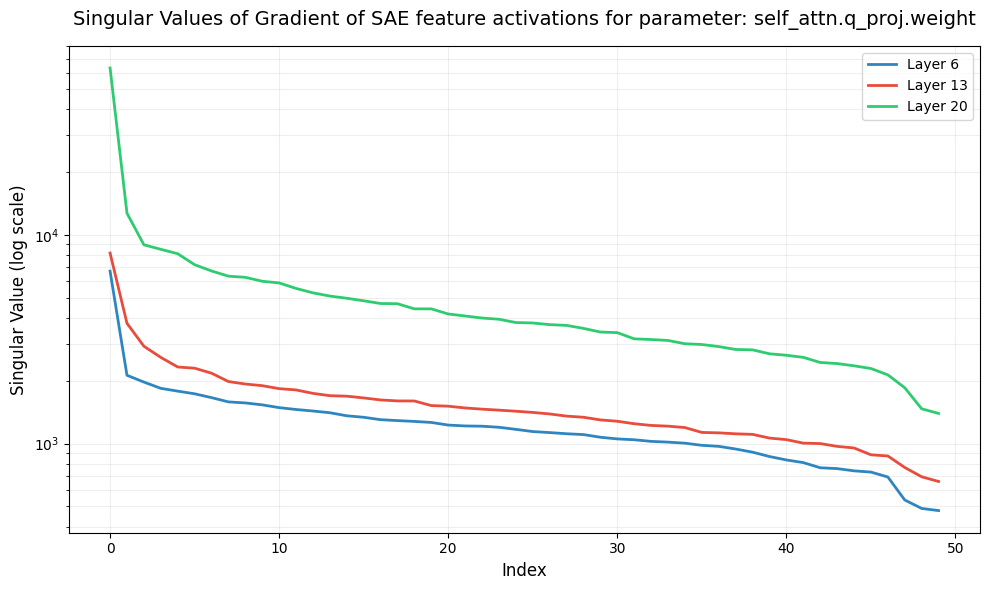

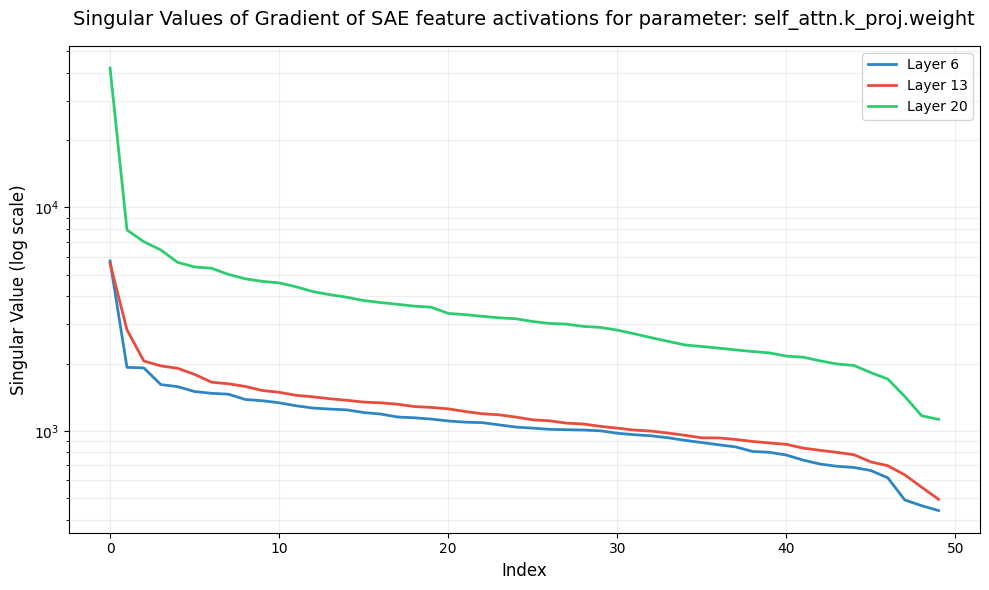

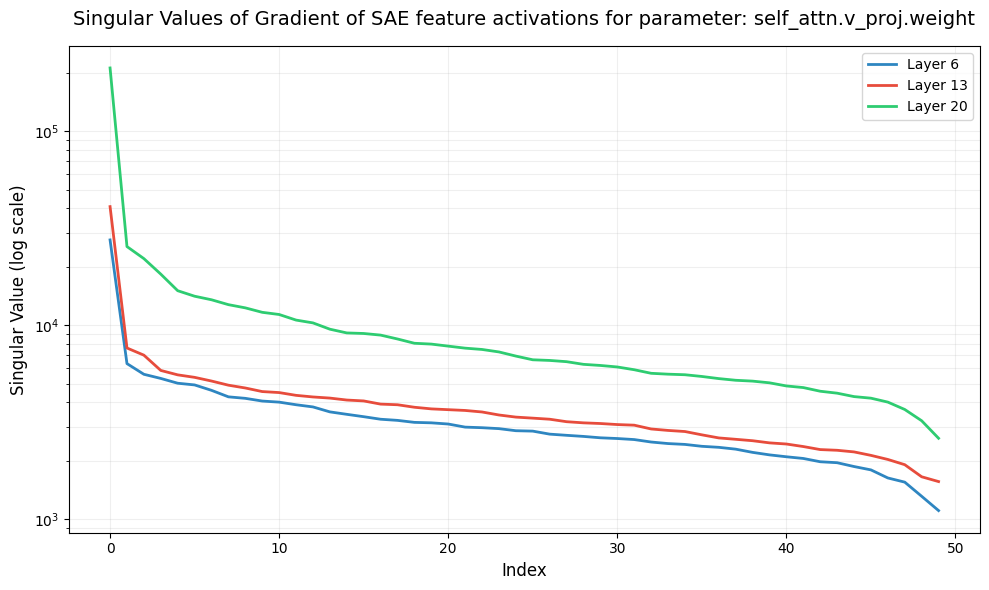

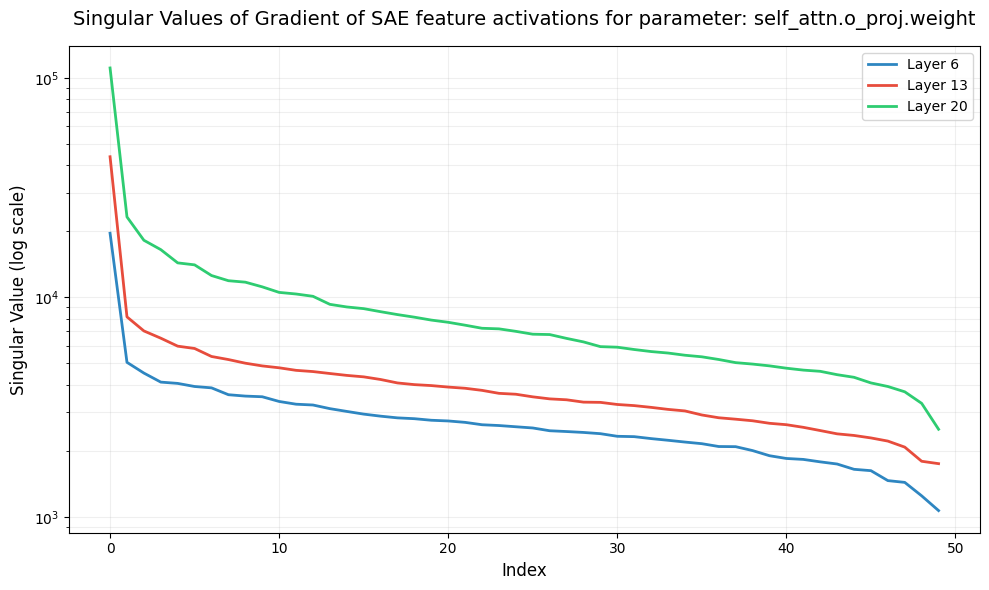

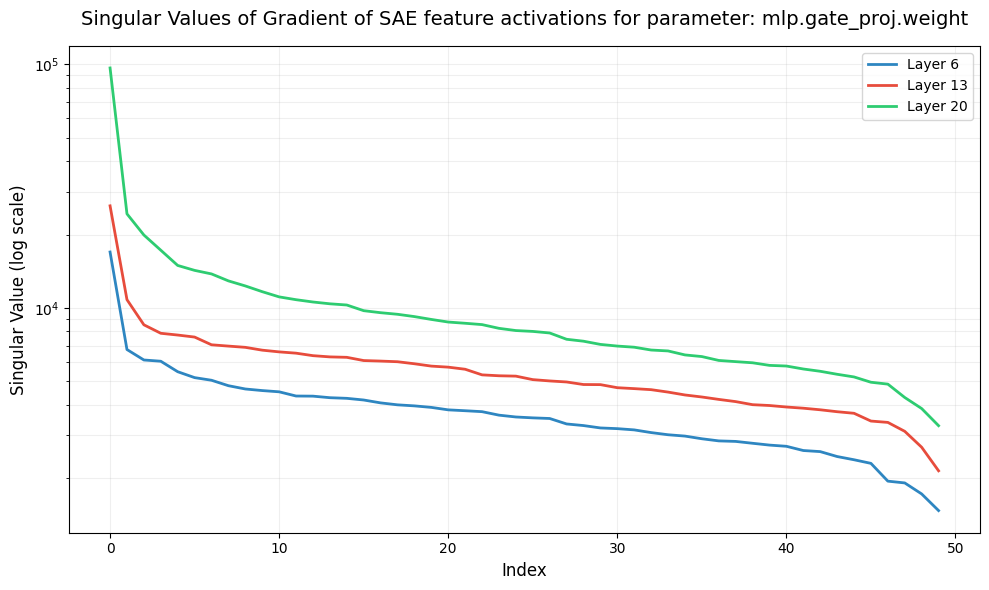

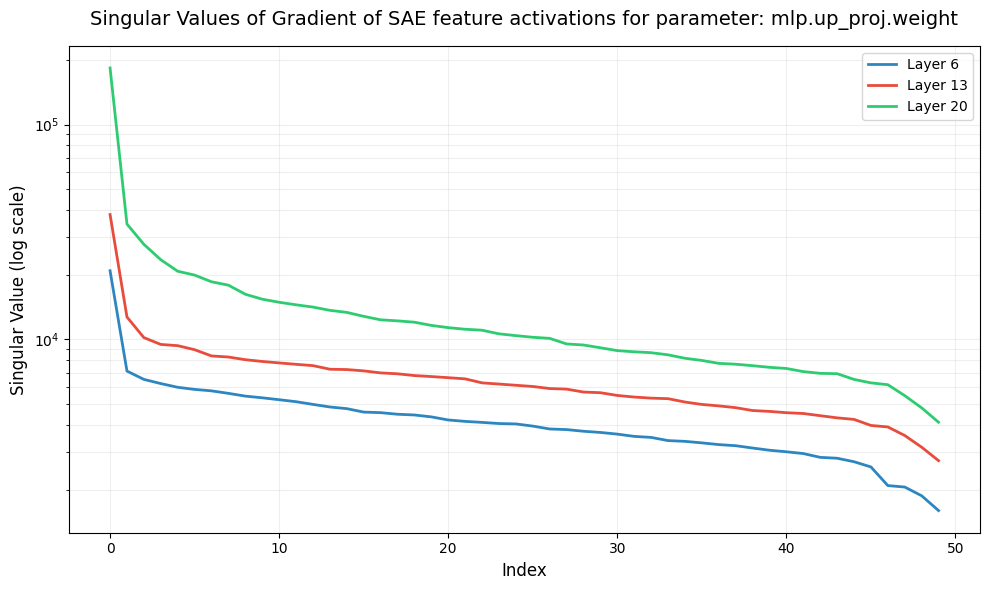

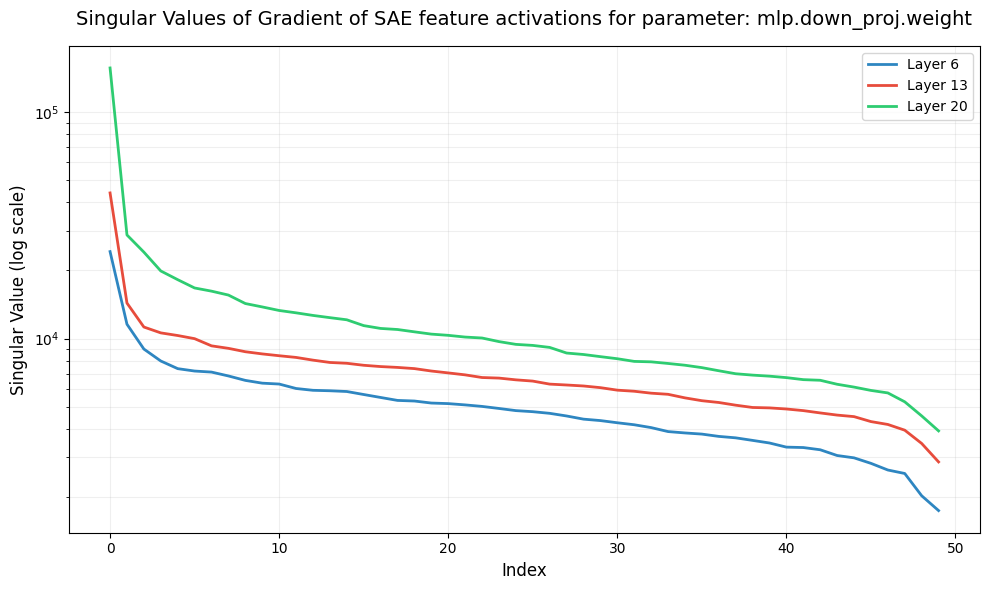

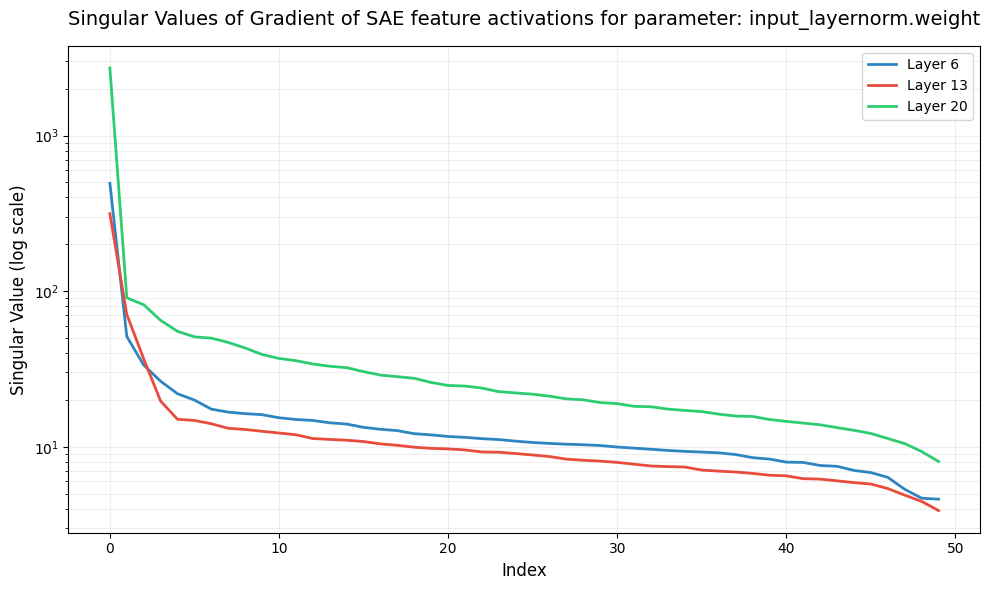

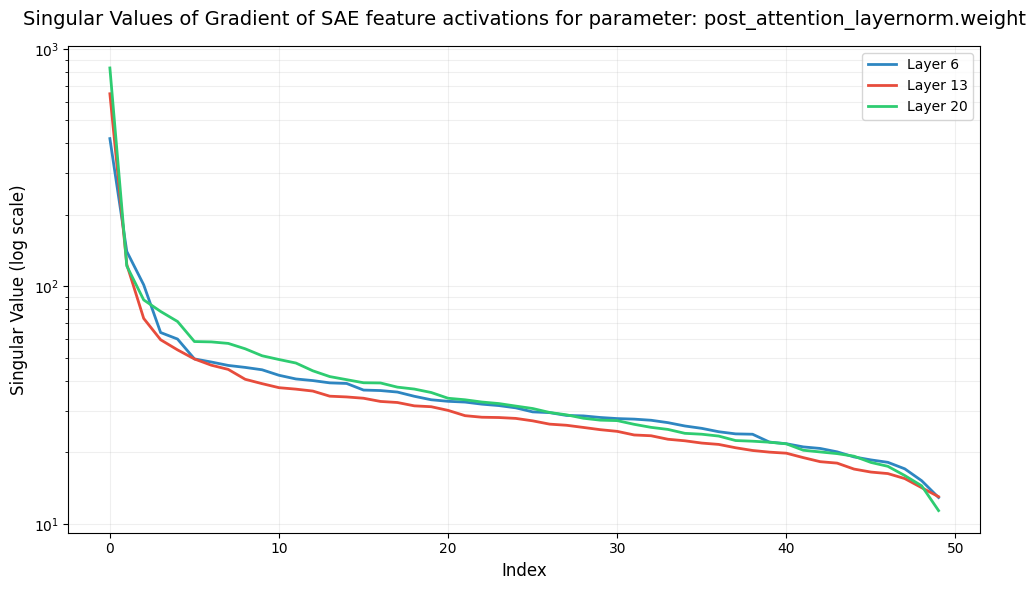

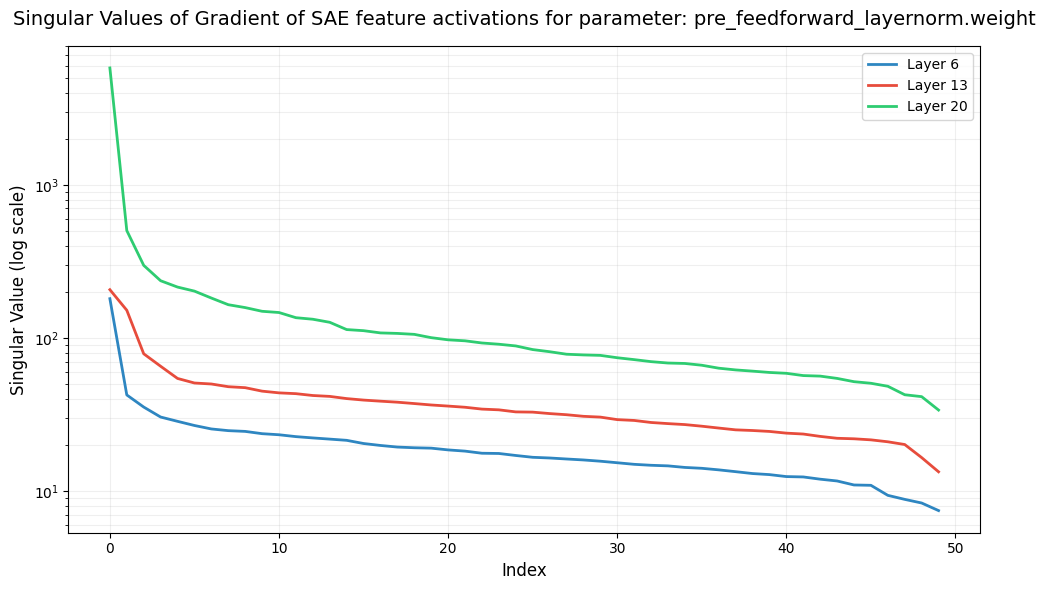

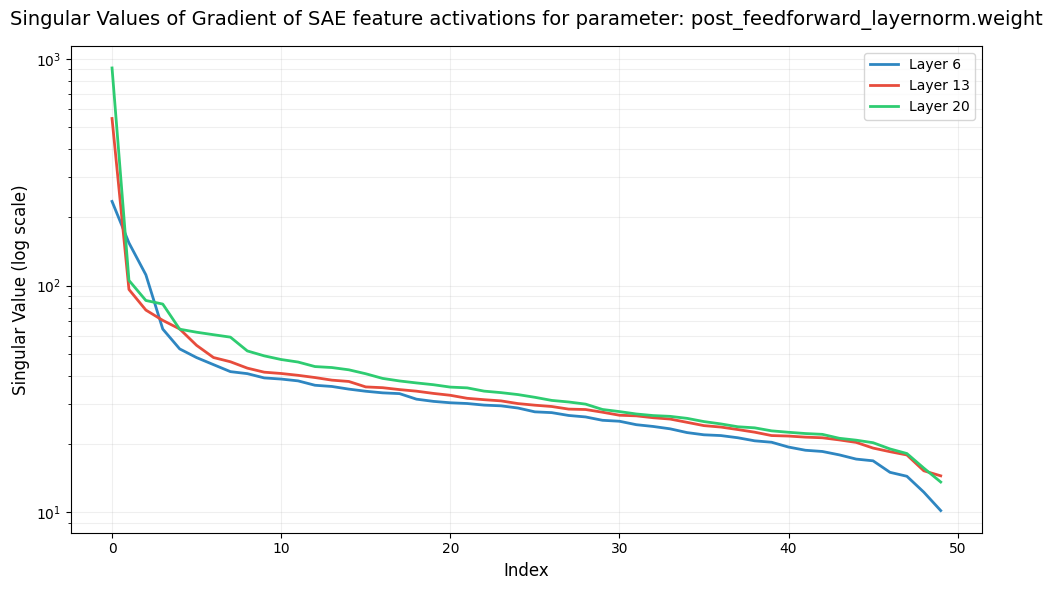

In [22]:
import matplotlib.pyplot as plt

# Set up colors for different layers
colors = ['#2E86C1', '#E74C3C', '#2ECC71']  # Blue, Red, Green
layer_names = {6: 'Layer 6', 13: 'Layer 13', 20: 'Layer 20'}

# Plot each parameter in a separate figure
for param_name, layer_data in layer_singular_values.items():
    plt.figure(figsize=(10, 6))
    
    # Plot each layer's singular values
    for layer_idx, (layer, singular_values) in enumerate(layer_data.items()):
        plt.plot(singular_values.cpu().numpy(), 
                color=colors[layer_idx], 
                label=layer_names[layer],
                linewidth=2)
    
    # Customize the plot
    plt.yscale('log')
    plt.title(f'Singular Values of Gradient of SAE feature activations for parameter: {param_name}', fontsize=14, pad=15)
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Singular Value (log scale)', fontsize=12)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(fontsize=10)
    
    plt.tight_layout()
    plt.show()

## Restricting Gradients

In [ ]:
top_k_ranks = 1
def restrict_gradients(param_grad, A_matrix):
    # A_matrix is the matrix of the first k columns of the U matrix from SVD
    # shape (flattened_grad_size, k), 
    original_param_shape = param_grad.shape
    flattened_param_grad = param_grad.flatten()
    low_rank_grad = einops.einsum(flattened_param_grad, A_matrix, "flattened_grad_size, flattened_grad_size k -> k")
    reprojected_grad = einops.einsum(low_rank_grad, A_matrix, "k, flattened_grad_size k -> flattened_grad_size")
    reshaped_grad = reprojected_grad.reshape(original_param_shape)
    return reshaped_grad

